# AP-1 Figures

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Functions

In [2]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [3]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [4]:
def signmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

## Copy Score Files

In [5]:
%%bash
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./

# # C57BL6J files
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_C57BL6J.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_C57BL6J.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_C57BL6J.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_C57BL6J.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_C57BL6J.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/C57BL6J.fa ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_C57BL6J.pickle ./

# # BALBCJ files
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/BALBCJ.fa ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_count_frame_BALBCJ.pickle ./

# # tag count files 
# cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/merged_annotated_peaks_ap1TagCounts.tsv ./

# random background files
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_count_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_score_background_frame_C57BL6J.pickle ./  
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_start_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_end_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_sequence_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_strand_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J_background.fa ./

## Read in Score Files

In [6]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
motif_count_frame=pd.read_pickle('motif_count_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# scaler = preprocessing.MinMaxScaler()
# normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
# normed_motif_frame.columns = motif_score_frame.columns.values[3:]
# normed_motif_frame.index = motif_score_frame.index.values

# scaler = preprocessing.StandardScaler()
# standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
# standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
# standardized_motif_frame.index = motif_score_frame.index.values

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

# ### read in sequences as dictionary {peakID: sequence}
# with open('./peak_sequences/C57BL6J.fa') as f:
#     data = f.readlines()

# _id_sequence_dict = {}
# for line in data:
#     if line[0] == '>':
#         sequenceName = line.strip()[1:]
#     else:
#         _id_sequence_dict[sequenceName] = line.strip().upper()    

In [7]:
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_C57BL6J.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_C57BL6J.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_C57BL6J.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_C57BL6J.pickle')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_C57BL6J.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_C57BL6J.pickle')

# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]

# scaler = preprocessing.StandardScaler()
# standardized_motif_randomBackground_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
# standardized_motif_randomBackground_frame.columns = motif_score_background_frame.columns.values[3:]
# standardized_motif_randomBackground_frame.index = motif_score_background_frame.index.values

In [8]:
# concatent target and background frames
all_score_frame = pd.concat([motif_score_frame, motif_score_background_frame])
all_score_frame = all_score_frame[motif_score_frame.columns.values]
scaler = preprocessing.StandardScaler()
all_standardized_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_standardized_score_frame.columns = all_score_frame.columns.values[3:]
all_standardized_score_frame.index = all_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
all_normed_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_normed_score_frame.columns = all_score_frame.columns.values[3:]
all_normed_score_frame.index = all_score_frame.index.values


In [9]:
# Read in peak sequence
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [10]:
### work with just intergenic peaks for now ###
# intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
# intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
# intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
# intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
# intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
# intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
# intergenic_standardized_motif_frame = standardized_motif_frame[standardized_motif_frame.index.isin(intergenic_ids)]
# intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
# intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [11]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

# Figure 1 - AP-1 Cistrome

### Expression of AP-1 monomers before and after KLA treatment

In [265]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/> rpkm_untreated.tsv

# python ~/code/seq_merge_pipe/run_idr_homerRNA.py rpkm_untreated.tsv ./rna_idr_untreated KLA KLA Veh Veh

	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-26/
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26/
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR

In [212]:
# idr_rpkm_frame = pd.read_csv('./rna_idr_untreated/idr_union.tsv', sep='\t')

# columns = idr_rpkm_frame.columns.values
# columns[0] = "refseq"
# for i in range(len(columns)):
#     if "FPKM" in columns[i]:
#         columns[i] = '_'.join(columns[i].split('/')[-2].split('_')[3:5])
# idr_rpkm_frame.columns = columns    
# idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence'].values]
# idr_rpkm_frame.index = idr_rpkm_frame['gene'].values

# idr_rpkm_mean_frame = pd.DataFrame()

# for treatment in idr_rpkm_frame.columns.values[8:-1]:
#     idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment].astype(float), axis=1)

In [13]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

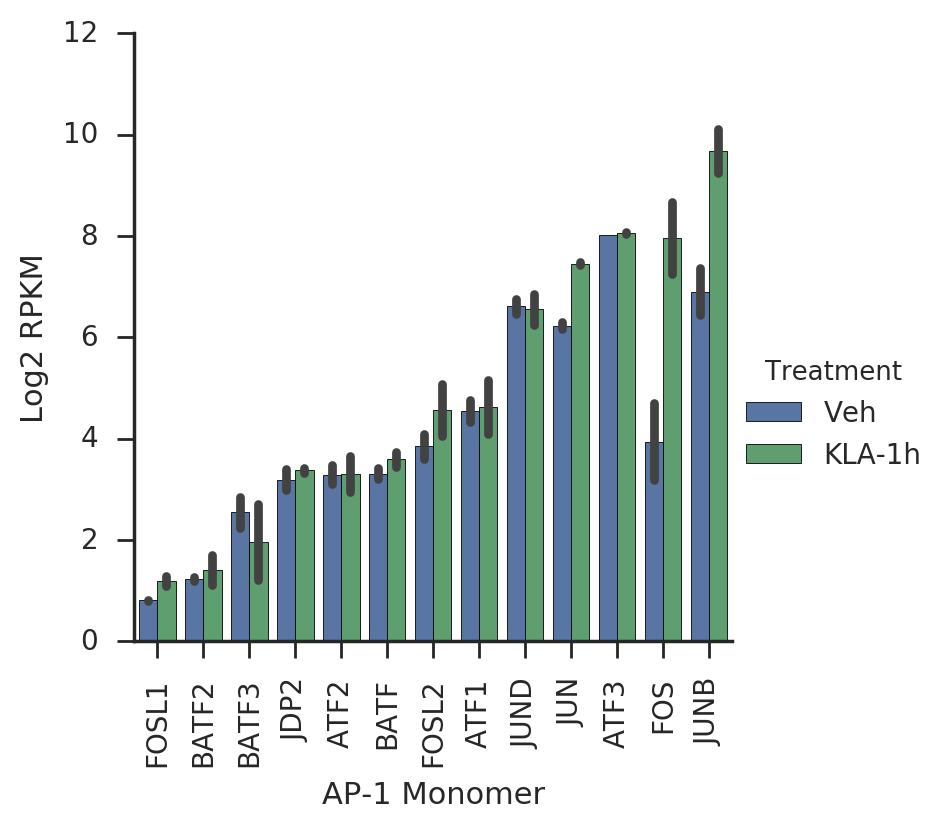

In [24]:
gene_list = ['ATF', 'ATF1', 'ATF2', 'ATF3', #'ATF4', #'ATF5', 'ATF6', 'ATF7',
             'BATF', 'BATF1', 'BATF2', 'BATF3', 'BATF4',
             'FOS', 'FOSL1', 'FOSL2', #'FOSLB',
             'JDP2', 'JUN' , 'JUNB', 'JUND']
# gene_list = ['ATF3', 'FOS', 
#              'JUN' , 'JUNB', 'JUND']
plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='Gene', 
                   y='Log2 RPKM', 
                   hue='Treatment', 
                   kind='bar', 
                   order = ordered_genes,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
    plt.xlabel('AP-1 Monomer')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_a.svg', bbox_inches='tight')

### Heatmap of Vehicle Cistrome

In [ ]:
### create tag matrix
!annotatePeaks.pl ./merged_peaks_filtered.tsv mm10 -size given -d ./tag_directories_ap1/* /home/jtao/analysis/ap1_analysis/tag_directories/*p65*> merged_annotated_peaks_ap1.tsv

In [10]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('merged_annotated_peaks_ap1TagCounts.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[3:5]).split('-')[0] for x in columns]))

ap1_meanTag_dict = {}
for ft in factor_treatments:
    ap1_meanTag_dict[ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1).values
ap1_meanTag_frame = pd.DataFrame(ap1_meanTag_dict)
ap1_meanTag_frame = ap1_meanTag_frame[factor_treatments]
ap1_meanTag_frame.index = ap1_tag_frame.index.values

In [ ]:
# clustermap for Vehicle
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1_veh')].index.values
data = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)]\
    [['ATF3_Veh','cJun_Veh', 'Fos_Veh', 'JunB_Veh', 'JunD_Veh','Input_Veh']]
# normalize by input
data = data.div((data['Input_Veh'] + 1), axis=0)
data = data.ix[:,:-1]
logged_data = np.log2(data+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=[x.split('_')[0] for x in data.columns],
          cmap='Blues',
          col_cluster=False,
          vmax=4
          )
# plt.savefig('./figures/figure_01_b.svg', bbox_inches='tight')
# plt.savefig('./figures/figure_01_b.png', bbox_inches='tight')

### Heatmap of KLA Cistrome

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


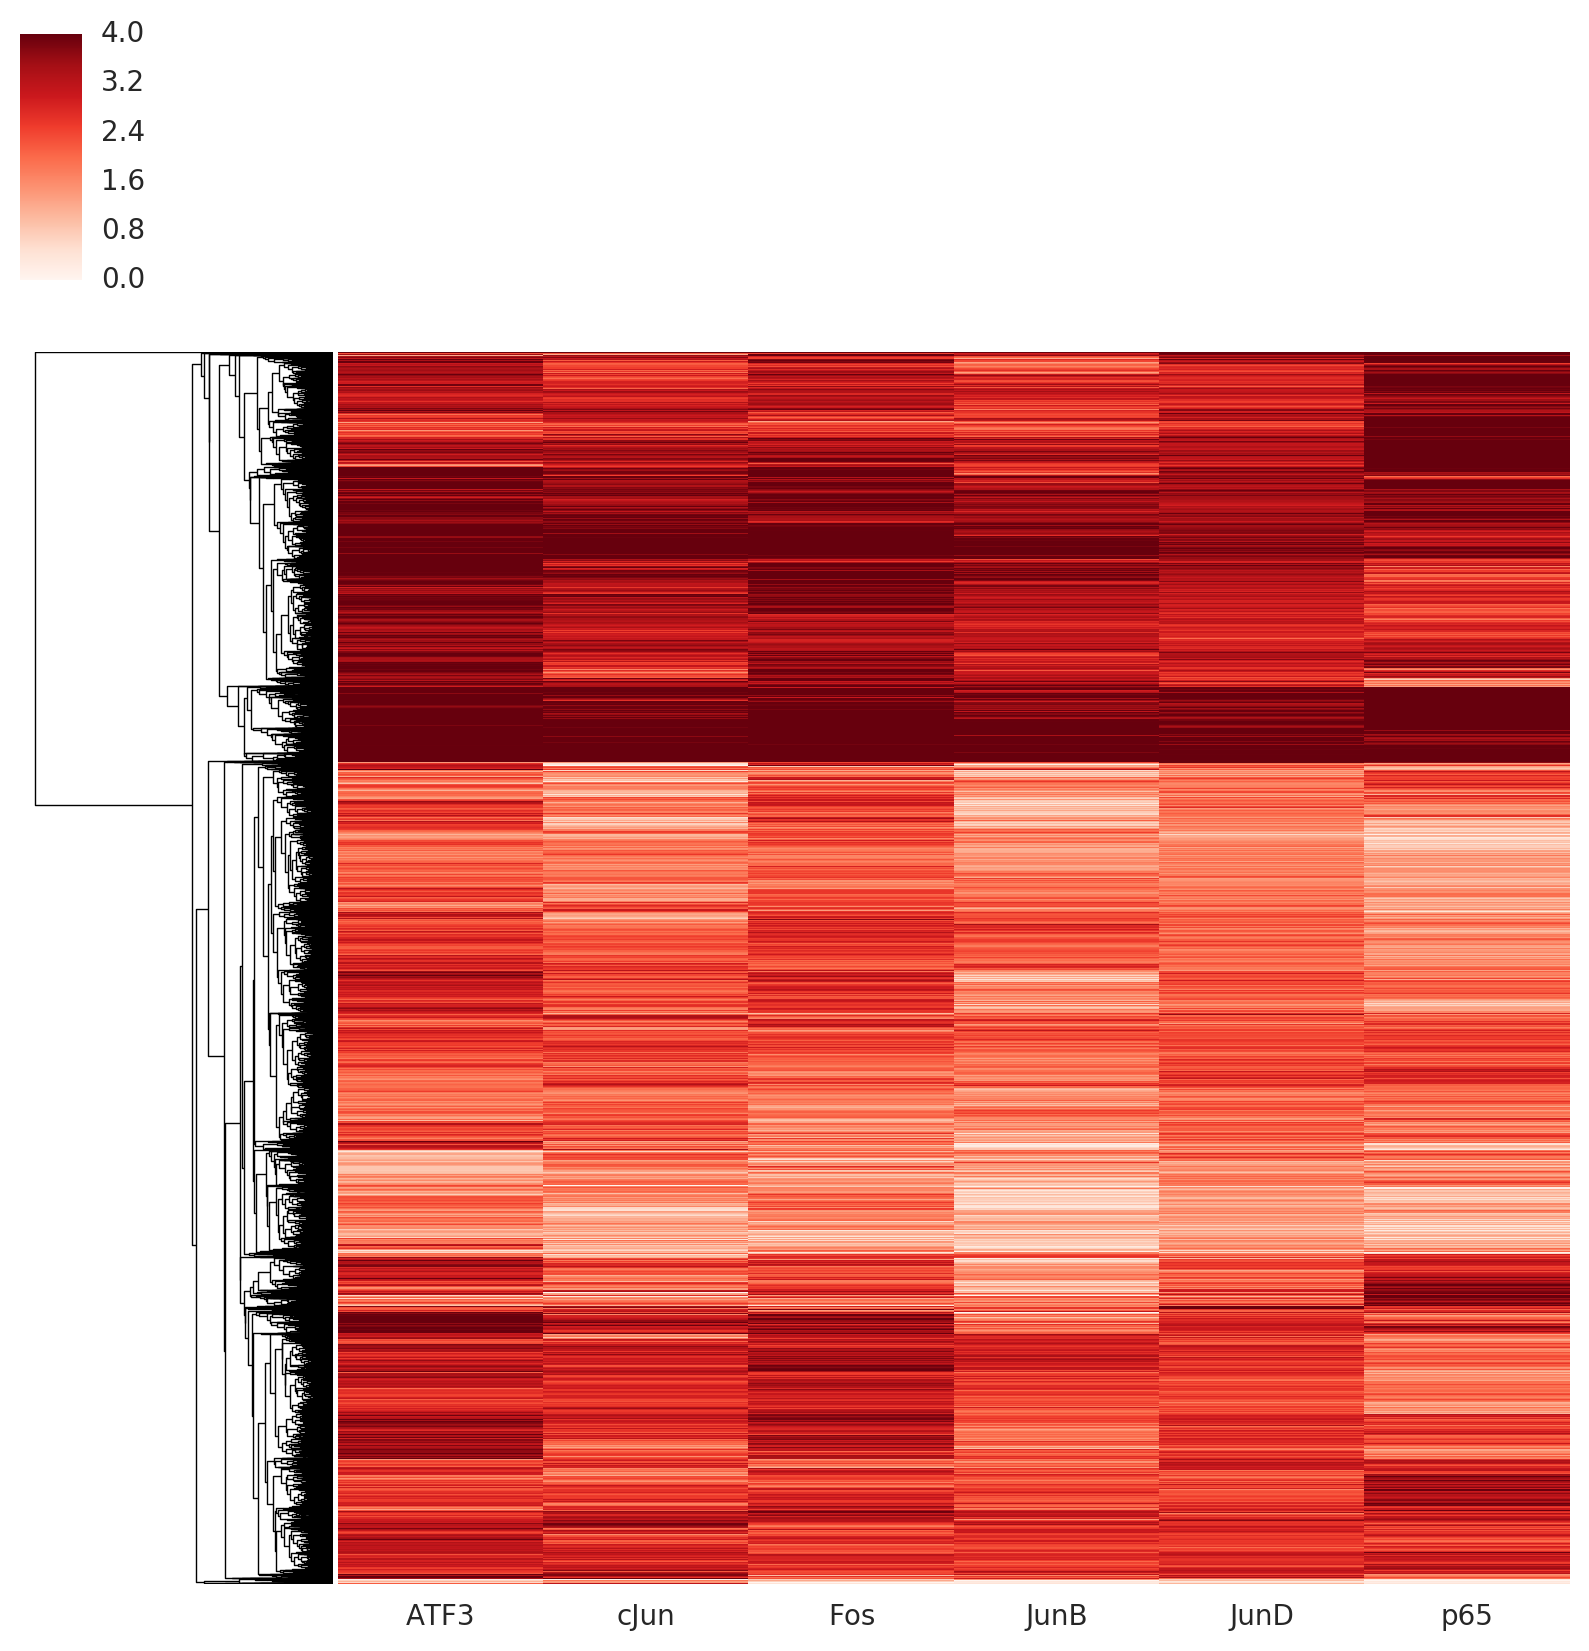

In [258]:
# clustermap for KLA
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1_kla')].index.values
data = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)]\
    [['ATF3_KLA','cJun_KLA', 'Fos_KLA', 'JunB_KLA', 'JunD_KLA', 'p65_KLA','Input_KLA']]
data = data.div((data['Input_KLA'] + 1), axis=0)
data = data.ix[:,:-1]
logged_data = np.log2(data+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=[x.split('_')[0] for x in data.columns],
          cmap='Reds',
          col_cluster=False,
          vmax=4)
plt.savefig('./figures/figure_01_c.svg', bbox_inches='tight')
plt.savefig('./figures/figure_01_c.png', bbox_inches='tight')

### Heatmap for both Vehicle and KLA

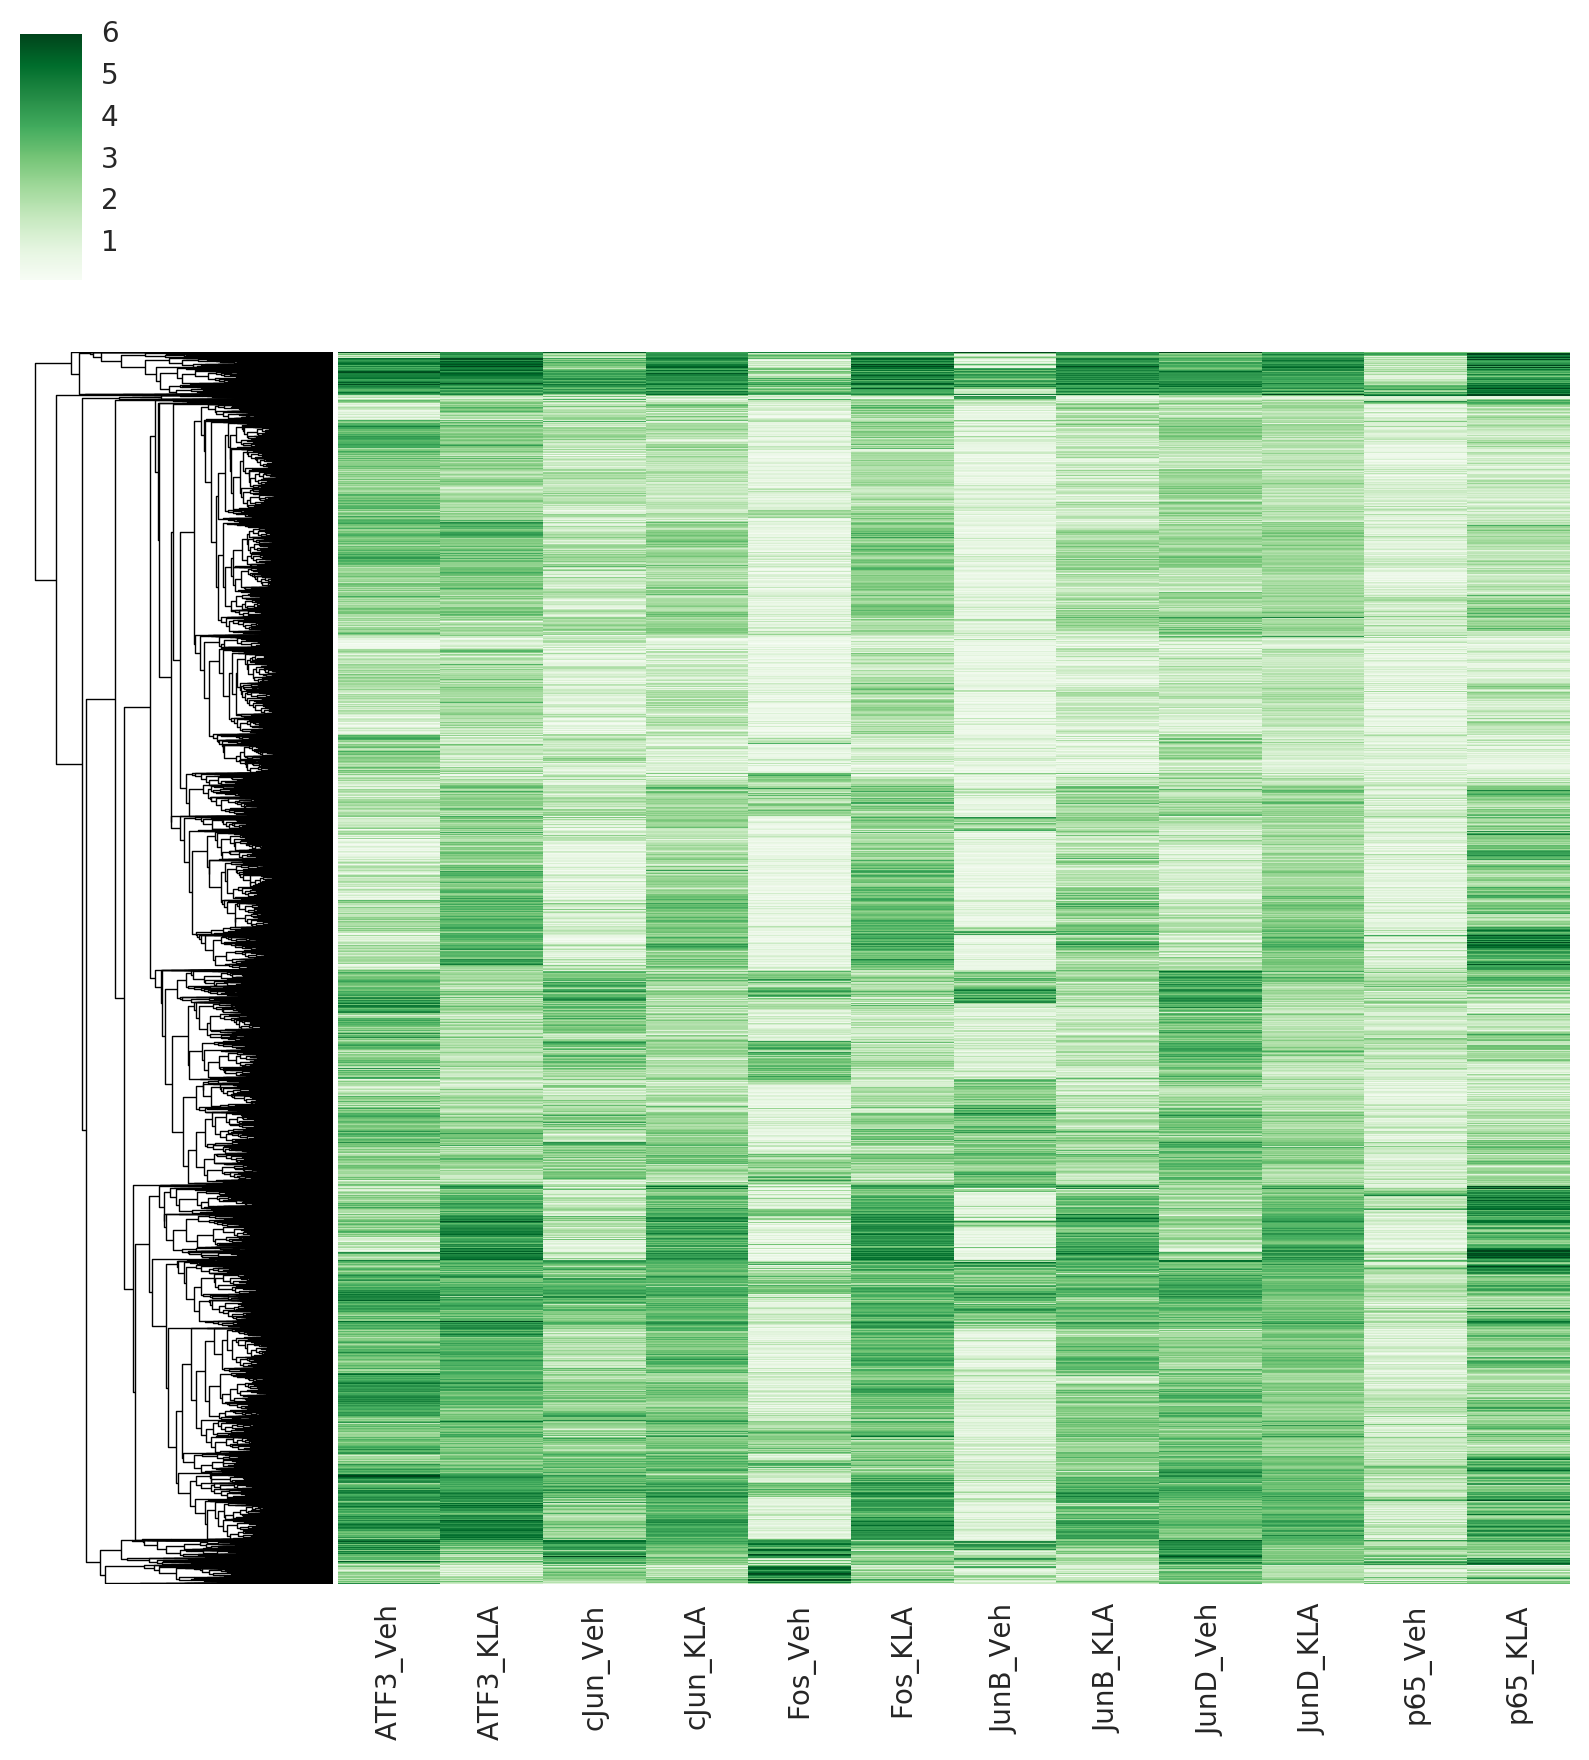

In [28]:
# clustermap for KLA
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].index.values
ap1_normedTag_frame = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)][[]]
for factor in ['ATF3','cJun', 'Fos', 'JunB', 'JunD', 'p65']:
    for treatment in ['Veh','KLA']:
        ft = factor + '_' + treatment
        ap1_normedTag_frame[ft] = (ap1_meanTag_frame[ft] + 1)/(ap1_meanTag_frame['Input_'+treatment]+1)

logged_data = np.log2(ap1_normedTag_frame+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=logged_data.columns,
          cmap='Greens',
          col_cluster=False,
          vmax=6)


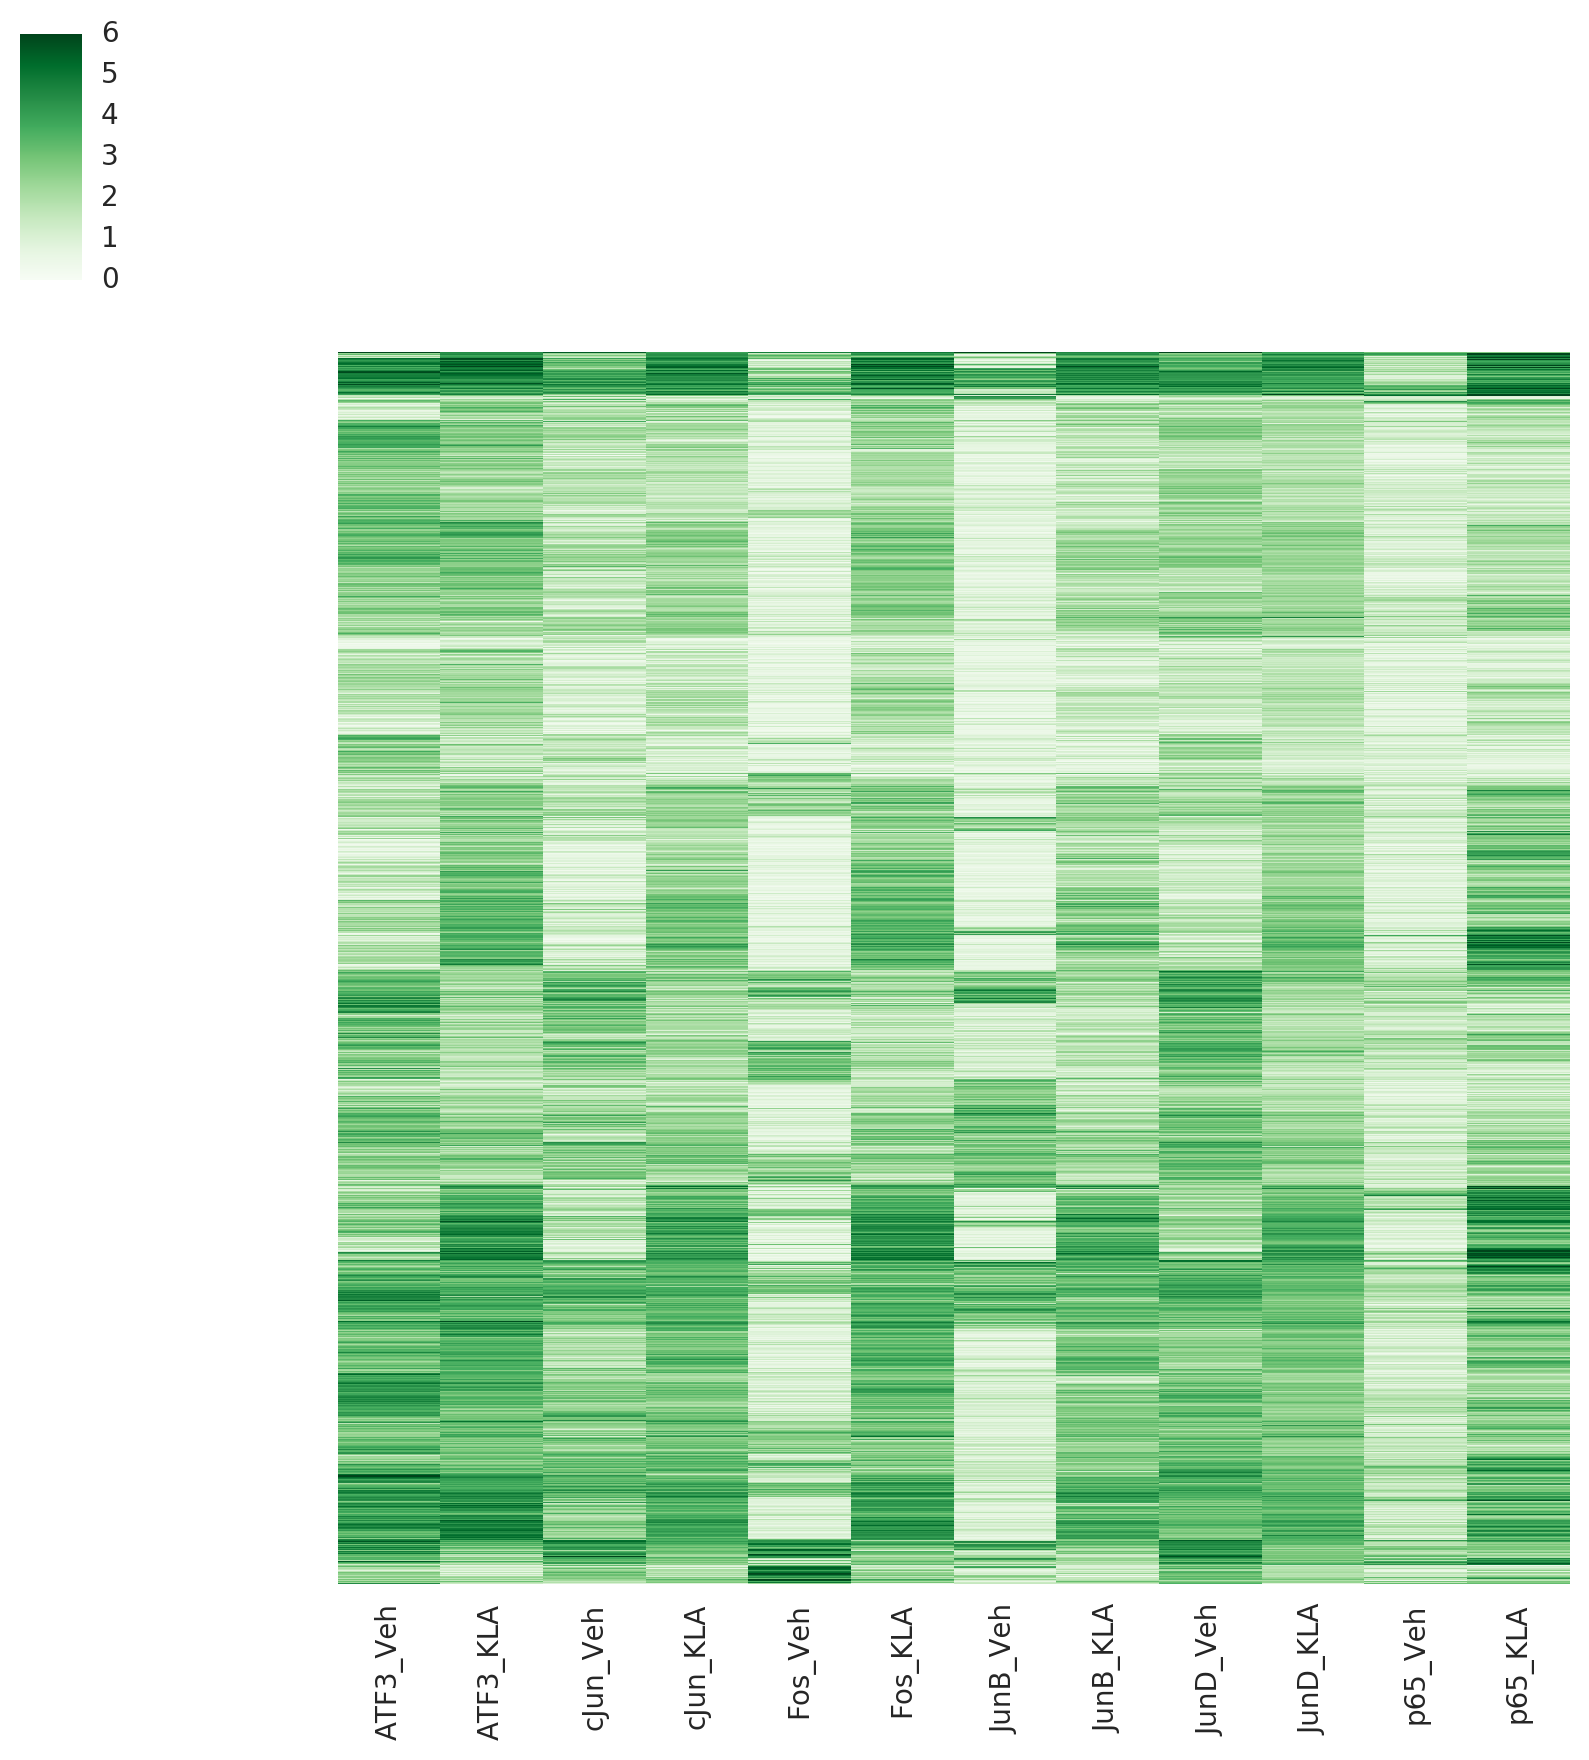

In [29]:
sns.clustermap(cg.data2d,
          yticklabels=False,
          xticklabels=logged_data.columns,
          cmap='Greens',
          col_cluster=False,
          row_cluster=False,
          vmin=0,
          vmax=6)

# plt.savefig('./figures/figure_01_b-c.svg', bbox_inches='tight')
plt.savefig('./figures/figure_01_b-c.png', bbox_inches='tight')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


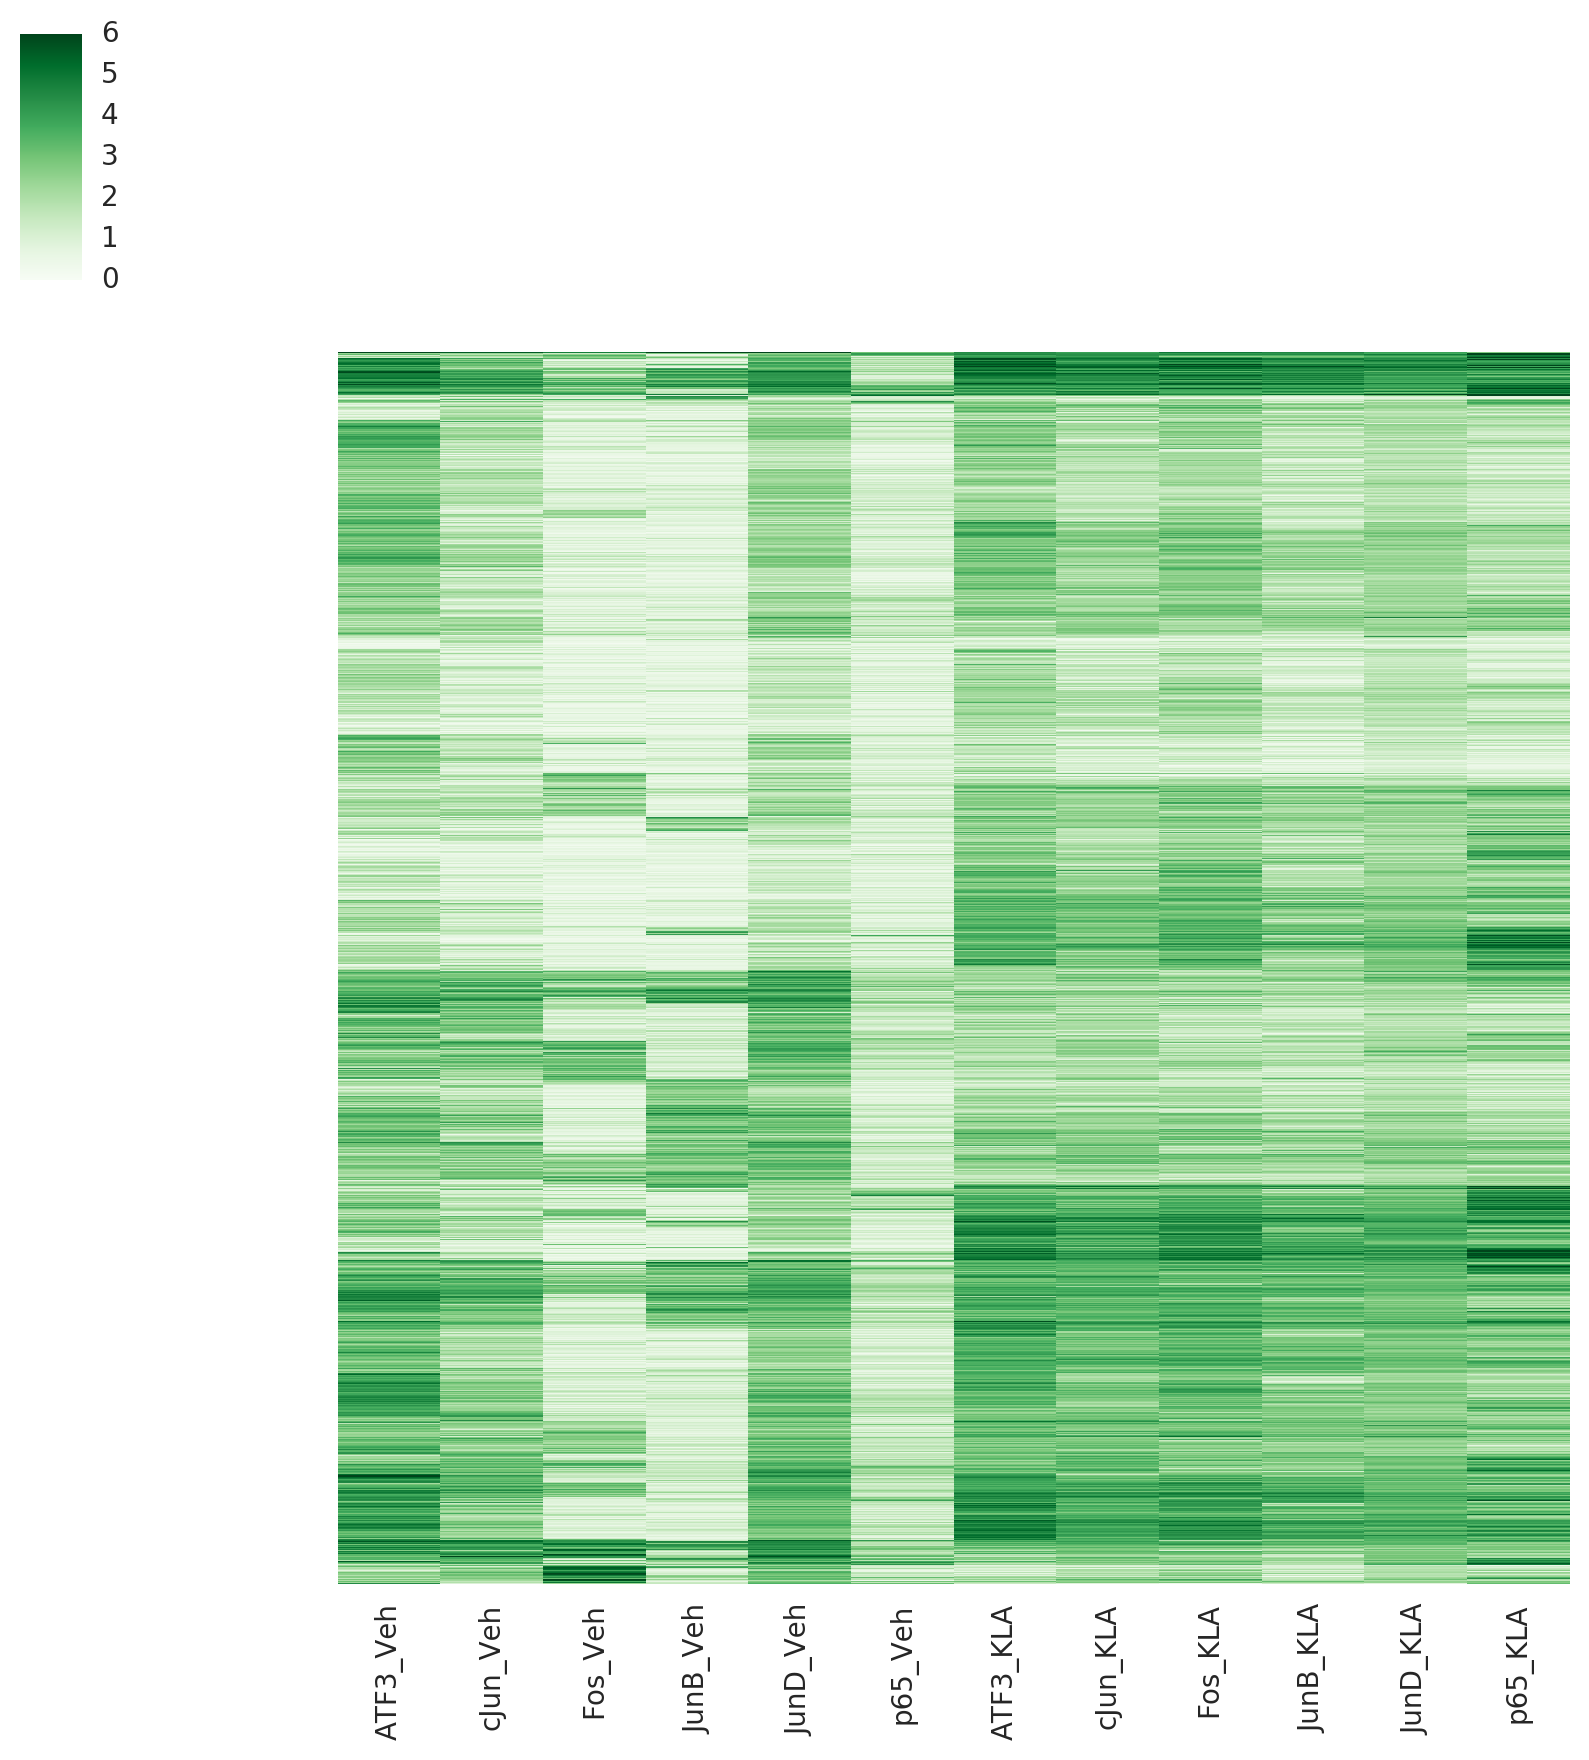

In [30]:
sorted_columns = []
for treatment in ['Veh', 'KLA']:
    for factor in ['ATF3','cJun', 'Fos', 'JunB', 'JunD', 'p65']:
        sorted_columns.append(factor + '_' + treatment)
    
sns.clustermap(cg.data2d[sorted_columns],
          yticklabels=False,
          xticklabels=sorted_columns,
          cmap='Greens',
          col_cluster=False,
          row_cluster=False,
          vmin=0,
          vmax=6)

# plt.savefig('./figures/figure_01_b-c.svg', bbox_inches='tight')
plt.savefig('./figures/figure_01_b-c_byTreatment.png', bbox_inches='tight')

### Stacked barplot summarizing heatmaps

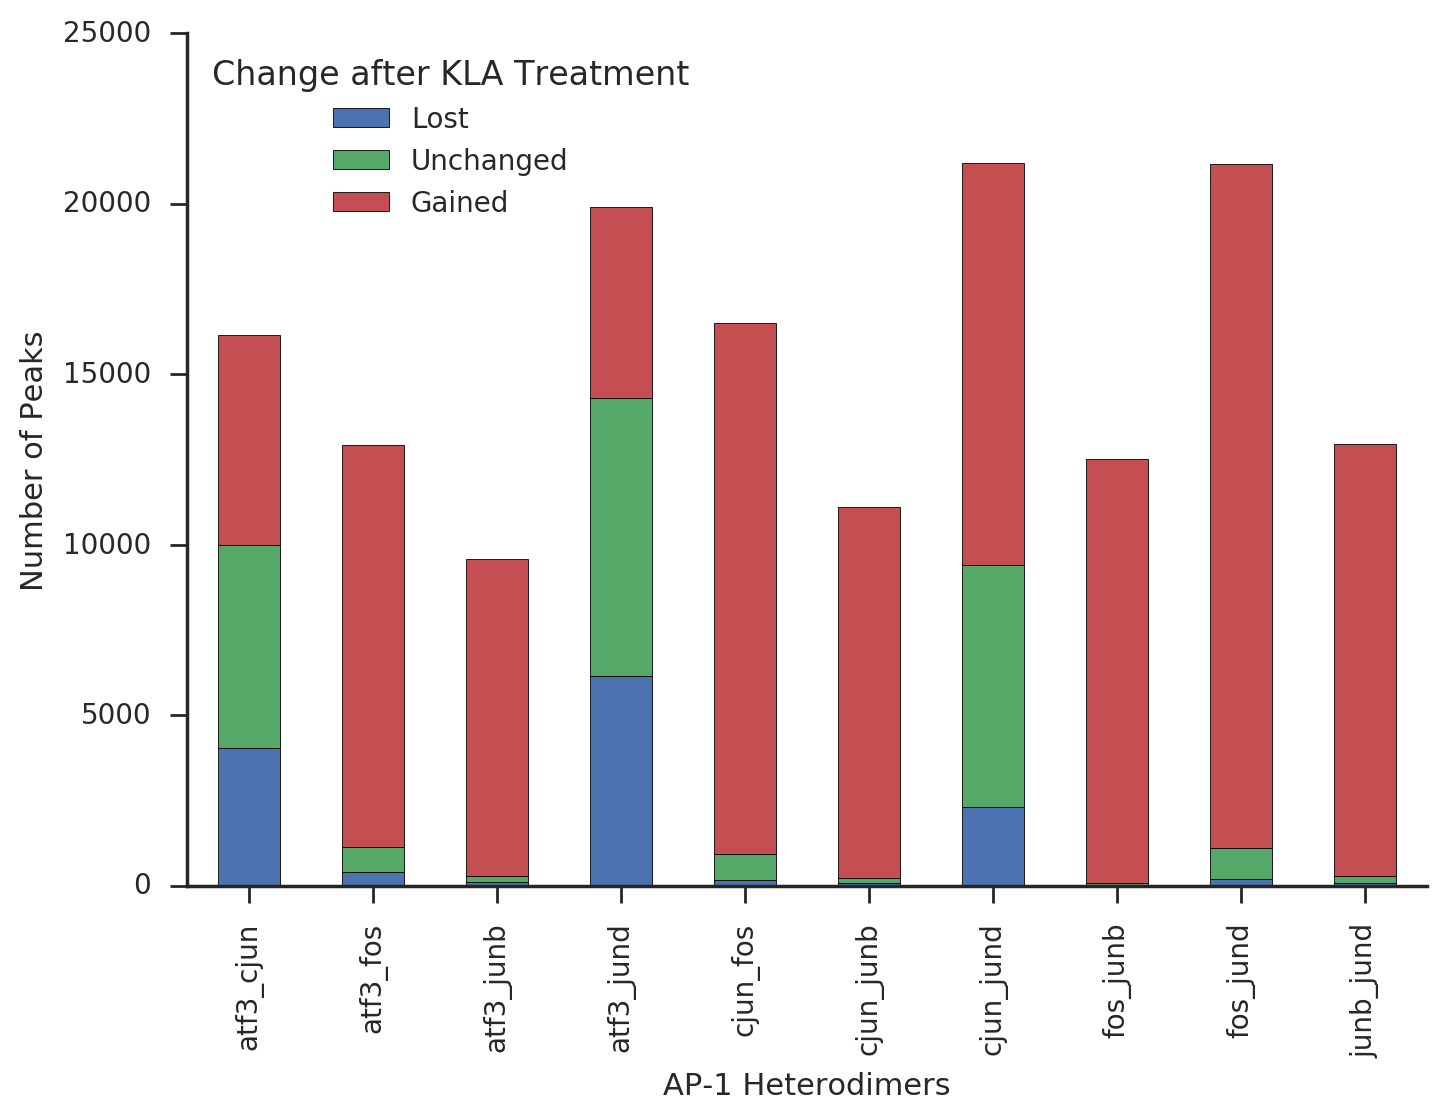

In [31]:
threshold = 0
# ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
ap1_members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
factors = []
veh_counts = []
both_counts = []
kla_counts = []

veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]


for i in range(len(ap1_members)):
    factor1 = ap1_members[i]
    for j in range(i, len(ap1_members)):
        factor2 = ap1_members[j]
        
        if factor1 == factor2:
            veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
                                       (summary_frame['c57bl6_' + factor1 + '_veh'] == summary_frame[veh_columns].sum(axis=1))].index.values)
            kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
                                       (summary_frame['c57bl6_' + factor1 + '_kla'] == summary_frame[kla_columns].sum(axis=1))].index.values)
        else:
            veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
                                       (summary_frame['c57bl6_' + factor2 + '_veh'] > 0)].index.values)
            kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
                                       (summary_frame['c57bl6_' + factor2 + '_kla'] > 0)].index.values)
        
        veh_count = len(veh_indices.difference(kla_indices))
        both_count = len(veh_indices.intersection(kla_indices))
        kla_count = len(kla_indices.difference(veh_indices))
        
        if max([veh_count, both_count, kla_count]) > threshold and not factor1==factor2:
            if factor1 == factor2:
                factors .append(factor1)
            else:            
                factors.append(factor1 + '_' + factor2)
            veh_counts.append(veh_count)
            both_counts.append(both_count)
            kla_counts.append(kla_count)
plottingFrame = pd.DataFrame({'Lost':veh_counts,
                              'Unchanged':both_counts,
                              'Gained':kla_counts})
plottingFrame = plottingFrame[['Lost', 'Unchanged', 'Gained']]
plottingFrame.index = factors
with sns.axes_style('ticks',{'axes.grid':False, 'grid.color':'white'}):
    plottingFrame.plot(kind='bar',stacked=True)
    sns.despine()
    plt.gca().get_legend().set_title('Change after KLA Treatment')
    plt.xlabel('AP-1 Heterodimers')
    plt.ylabel('Number of Peaks')

plt.savefig('./figures/figure_01_d.svg', bbox_inches='tight')

In [108]:
# threshold = 0
# ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
# factors = []
# veh_counts = []
# both_counts = []
# kla_counts = []

# veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
# kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]


# for i in range(len(ap1_members)):
#     factor1 = ap1_members[i]
#     for j in range(i, len(ap1_members)):
#         factor2 = ap1_members[j]
        
#         if factor1 == factor2:
#             veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
#                                        (summary_frame['c57bl6_' + factor1 + '_veh'] == summary_frame[veh_columns].sum(axis=1))].index.values)
#             kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
#                                        (summary_frame['c57bl6_' + factor1 + '_kla'] == summary_frame[kla_columns].sum(axis=1))].index.values)
#         else:
#             veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
#                                        (summary_frame['c57bl6_' + factor2 + '_veh'] > 0)].index.values)
#             kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
#                                        (summary_frame['c57bl6_' + factor2 + '_kla'] > 0)].index.values)
        
#         veh_count = len(veh_indices.difference(kla_indices))
#         both_count = len(veh_indices.intersection(kla_indices))
#         kla_count = len(kla_indices.difference(veh_indices))
        
#         if max([veh_count, both_count, kla_count]) > threshold:
#             if factor1 == factor2:
#                 factors.append(factor1)
#             else:            
#                 factors.append(factor1 + '_' + factor2)
#             veh_counts.append(veh_count)
#             both_counts.append(both_count)
#             kla_counts.append(kla_count)
# plottingFrame = pd.DataFrame({'Lost':veh_counts,
#                               'Unchanged':both_counts,
#                               'Gained':kla_counts})
# plottingFrame = plottingFrame[['Lost', 'Unchanged', 'Gained']]
# plottingFrame.index = factors
# with sns.axes_style('ticks',{'axes.grid':False, 'grid.color':'white'}):
#     plottingFrame.plot(kind='bar',stacked=True)
#     sns.despine()
#     plt.gca().get_legend().set_title('Change after KLA Treatment')
#     plt.xlabel('AP-1 Heterodimers')
#     plt.ylabel('Number of Peaks')

# plt.savefig('./figures/figure_01_d_withHomoDimers.svg', bbox_inches='tight')

### Scatter plot of tag counts for two similar monomers

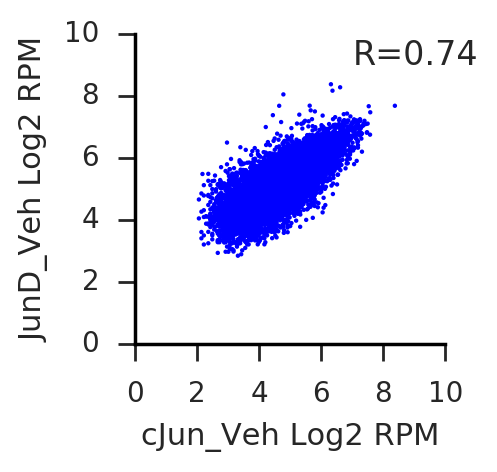

In [32]:
monomer1 = 'cJun_Veh'
monomer2 = 'JunD_Veh'
plt.figure(figsize=(2,2))
indices = summary_frame[(summary_frame['c57bl6_' + monomer1.lower()] > 0) & 
                        (summary_frame['c57bl6_' + monomer2.lower()] > 0)].index.values
x_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer1]
y_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer2]

log_x_vals = np.log2(x_vals + 1)
log_y_vals = np.log2(y_vals + 1)
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    plt.scatter(log_x_vals, 
                log_y_vals, 
                marker = '.', 
                s=10,
                edgecolors='none')
    
    sns.despine()
    # annotate axes 
    plt.xlabel(monomer1 + ' Log2 RPM')
    plt.ylabel(monomer2 + ' Log2 RPM')
    pearson, pearson_p = scipy.stats.pearsonr(x_vals, y_vals)
    plt.annotate(xy=(7,9), s='R='+ '{:.2f}'.format(pearson), )
    plt.xlim(0,10)
    plt.ylim(0,10)

    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    plt.savefig('./figures/figure_01_e.svg', bbox_inches='tight')

### Scatter plot of tag counts for two dissimilar monomers

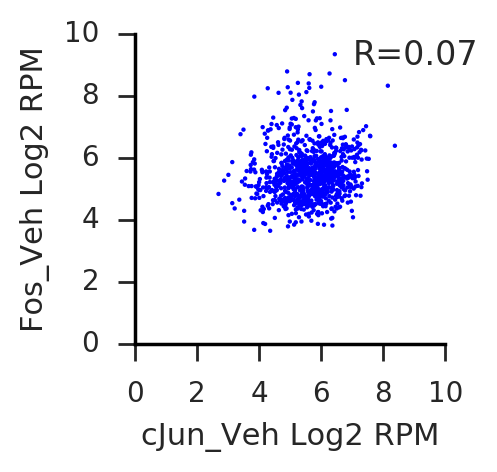

In [33]:
monomer1 = 'cJun_Veh'
monomer2 = 'Fos_Veh'
plt.figure(figsize=(2,2))
indices = summary_frame[(summary_frame['c57bl6_' + monomer1.lower()] > 0) & 
                        (summary_frame['c57bl6_' + monomer2.lower()] > 0)].index.values
x_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer1]
y_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer2]

log_x_vals = np.log2(x_vals + 1)
log_y_vals = np.log2(y_vals + 1)
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    plt.scatter(log_x_vals, 
                log_y_vals, 
                marker = '.', 
                s=10,
                edgecolors='none')
    
    sns.despine()
    # annotate axes 
    plt.xlabel(monomer1 + ' Log2 RPM')
    plt.ylabel(monomer2 + ' Log2 RPM')
    pearson, pearson_p = scipy.stats.pearsonr(x_vals, y_vals)
    plt.annotate(xy=(7,9), s='R='+ '{:.2f}'.format(pearson), )
    plt.xlim(0,10)
    plt.ylim(0,10)

    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    plt.savefig('./figures/figure_01_f.svg', bbox_inches='tight')

# Figure 2 - De Novo Motif Analysis

In [65]:
%%bash
### create motif analysis directories
if [ ! -d ./denovo_motif_analysis ]; 
then 
    # make directories for peaks
    mkdir ./denovo_motif_analysis;
    mkdir ./denovo_motif_analysis/veh_peaks;
    mkdir ./denovo_motif_analysis/kla_peaks;
    mkdir ./denovo_motif_analysis/veh_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/kla_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/veh_monomers_peaks;
    mkdir ./denovo_motif_analysis/kla_monomers_peaks;
    
    # make directories for motif analysis
    mkdir ./denovo_motif_analysis/veh_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_monomers;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_monomers;
    
    # make directories for top motifs
    mkdir ./denovo_motif_analysis/top_motifs_kla_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_nonoverlapping;
    mkdir ./denovo_motif_analysis/top_motifs_kla_nonoverlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_monomers;
    mkdir ./denovo_motif_analysis/top_motifs_kla_monomers;
else
    rm -rf ./denovo_motif_analysis/*/*
fi


### For overlapping dimer and monomer peaks

In [66]:
### create peak files for denovo motif
peak_threshold = 50 # minimum number of peaks required for running motif analysis
# factors = ['atf3', 'cjun', 'fos', 'fra1','fra2','jdp2','junb', 'jund']
factors = ['atf3', 'cjun', 'fos','junb', 'jund']

c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in factors]
for treatment in ['veh', 'kla']:
    for i in range(len(factors)):
        factor1 = 'c57bl6_'+factors[i] + '_' + treatment
        for j in range(i, len(factors)):
            factor2 = 'c57bl6_'+ factors[j] + '_' + treatment

            if factor1 == factor2:
                outputPath = './denovo_motif_analysis/' + treatment + '_monomers_peaks/' + factor1 + '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1] > 0)]
            else:
                outputPath = './denovo_motif_analysis/' + treatment + '_peaks/' + factor1 + '_' + factor2 + '_peaks.tsv'
                current_frame = summary_frame[(summary_frame[factor1]> 0) &
                                             (summary_frame[factor2] > 0)]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                outputPath = outputPath.replace('c57bl6_','')
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
    
done



	Position file = ./denovo_motif_analysis/veh_peaks/cjun_veh_fos_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_overlapping/cjun_veh_fos_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_peaks/atf3_veh_junb_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_overlapping/atf3_veh_junb_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_peaks/atf3_veh_cjun_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_overlapping/atf3_veh_cjun_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs

	Position file = ./d

In [68]:
%%bash
for peakFile in ./denovo_motif_analysis/kla_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
done


	Position file = ./denovo_motif_analysis/kla_peaks/cjun_kla_jund_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_overlapping/cjun_kla_jund_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_peaks/atf3_kla_junb_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_overlapping/atf3_kla_junb_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_peaks/atf3_kla_fos_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_overlapping/atf3_kla_fos_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mous

In [69]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 8 -S 3 &
    
done


	Position file = ./denovo_motif_analysis/veh_monomers_peaks/junb_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_monomers/junb_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_monomers_peaks/jund_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_monomers/jund_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_monomers_peaks/cjun_veh_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_monomers/cjun_veh
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs

	Position file = ./denovo_motif_analysis/veh_monomers_

In [70]:
%%bash
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 8 -S 3 &
    
done


	Position file = ./denovo_motif_analysis/kla_monomers_peaks/cjun_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_monomers/cjun_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/kla_monomers_peaks/jund_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_monomers/jund_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs

	Position file = ./denovo_motif_analysis/kla_monomers_peaks/atf3_kla_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_monomers/atf3_kla
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs
	Found mset for "mouse", will check against vertebrates

### For nonoverlapping dimer peaks

In [82]:
### create peak files for denovo motif analysis 
peak_threshold = 50 # minimum number of peaks required for running motif analysis

factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    


for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

for treatment in ['veh', 'kla']:
    c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in ap1_members]
    for i in range(len(factorPairs)):
        monomer1 = factorPairs[i][0] + '_' + treatment
        monomer2 = factorPairs[i][1] + '_' + treatment
            
        outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
            '-'.join(factorPairs[i]).replace('c57bl6_','') + '_nonoverlapping_peaks.tsv'
            
        current_frame = summary_frame[(summary_frame[[monomer1, monomer2]].sum(axis=1) == summary_frame[c57bl6_columns].sum(axis=1))
                                     & (summary_frame[monomer1] > 0) & (summary_frame[monomer2] > 0)]
        if current_frame.shape[0] >= peak_threshold:
            print(factorPairs[i], current_frame.shape)
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

('c57bl6_atf3', 'c57bl6_cjun') (1299, 44)
('c57bl6_atf3', 'c57bl6_fos') (105, 44)
('c57bl6_atf3', 'c57bl6_jund') (5457, 44)
('c57bl6_cjun', 'c57bl6_fos') (50, 44)


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('c57bl6_cjun', 'c57bl6_jund') (741, 44)
('c57bl6_fos', 'c57bl6_jund') (86, 44)
('c57bl6_atf3', 'c57bl6_cjun') (85, 44)
('c57bl6_atf3', 'c57bl6_fos') (80, 44)
('c57bl6_atf3', 'c57bl6_jund') (418, 44)
('c57bl6_cjun', 'c57bl6_fos') (538, 44)
('c57bl6_cjun', 'c57bl6_junb') (96, 44)
('c57bl6_cjun', 'c57bl6_jund') (2126, 44)
('c57bl6_fos', 'c57bl6_junb') (323, 44)
('c57bl6_fos', 'c57bl6_jund') (3077, 44)
('c57bl6_junb', 'c57bl6_jund') (334, 44)


In [83]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
done

%%bash
for peakFile in ./denovo_motif_analysis/kla_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
done

bash: line 8: fg: no job control

	Position file = ./denovo_motif_analysis/kla_nonoverlapping_peaks/cjun-fos_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/cjun-fos_nonoverlapping
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/veh_nonoverlapping_peaks/atf3-cjun_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/atf3-cjun_nonoverlapping
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs

	Position file = ./denovo_motif_analysis/veh_nonoverlapping_peaks/atf3-fos_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/atf3-fos_nonoverlapping
	Fragment size set to 200
	Motif length set at 8,
	Usi

#### For ATF3 cJun, JunD and Fos

In [226]:
! mkdir ./denovo_motif_analysis/atf3-jund_cjun-fos_peaks
! mkdir ./denovo_motif_analysis/atf3-jund_cjun-fos_motif_analysis

In [227]:
### create peak files for denovo motif analysis 
peak_threshold = 0 # minimum number of peaks required for running motif analysis

factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in factors]
for treatment in ['veh']:
    
    for i in range(len(factorPairs)):
        dimer1_monomer1 = factorPairs[i][0] + '_' + treatment
        dimer1_monomer2 = factorPairs[i][1] + '_' + treatment
        for j in range(len(factorPairs)):
            dimer2_monomer1 = factorPairs[j][0] + '_' + treatment
            dimer2_monomer2 = factorPairs[j][1] + '_' + treatment
            
            outputPath = './denovo_motif_analysis/atf3-jund_cjun-fos_peaks/' + \
                '-'.join(factorPairs[i]).replace('c57bl6_','') + '_not_' + \
                '-'.join(factorPairs[j]).replace('c57bl6_','') + '_nonoverlapping_peaks.tsv'
            current_frame = summary_frame[(summary_frame[dimer1_monomer1] > 0) &
                                          (summary_frame[dimer1_monomer2] > 0) &
                                          (summary_frame[dimer2_monomer1] == 0) &
                                          (summary_frame[dimer2_monomer2] == 0) ]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                print('-'.join(factorPairs[i]).replace('c57bl6_','') + '_not_' + \
                '-'.join(factorPairs[j]).replace('c57bl6_',''), current_peak_frame.shape[0])
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


atf3-cjun_not_fos-jund 1562
atf3-fos_not_cjun-jund 7
atf3-jund_not_cjun-fos 491
cjun-fos_not_atf3-jund 89
cjun-jund_not_atf3-fos 3009
fos-jund_not_atf3-cjun 346


In [228]:
%%bash
for peakFile in ./denovo_motif_analysis/atf3-jund_cjun-fos_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/atf3-jund_cjun-fos_motif_analysis/${peakName} -size 200 -len 8 -p 8 -S 3 &
done


	Position file = ./denovo_motif_analysis/atf3-jund_cjun-fos_peaks/atf3-fos_not_cjun-jund_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/atf3-jund_cjun-fos_motif_analysis/atf3-fos_not_cjun-jund_nonoverlapping
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs
	Found mset for "mouse", will check against vertebrates motifs

	Position file = ./denovo_motif_analysis/atf3-jund_cjun-fos_peaks/cjun-fos_not_atf3-jund_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/atf3-jund_cjun-fos_motif_analysis/cjun-fos_not_atf3-jund_nonoverlapping
	Fragment size set to 200
	Motif length set at 8,
	Using 8 CPUs
	Will optimize 3 putative motifs

	Position file = ./denovo_motif_analysis/atf3-jund_cjun-fos_peaks/atf3-cjun_not_fos-jund_nonoverlapping_peaks.tsv
	Genome = mm10
	Output Directory = ./denovo_motif_analysis/atf3-jund_cjun-fos_motif_analysis/atf3-cjun_not_fos-jund_nonoverlapping
	Frag

#### Get top motifs

In [84]:
%%bash
# get top motif for all heterodimers


for i in ./denovo_motif_analysis/veh_motif_analysis_overlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_overlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_overlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_overlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/veh_motif_analysis_monomers/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_monomers/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_monomers/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_monomers/${dimerName}.motif
done

In [85]:
%%bash
#create sequence logos for each top motif
mkdir ./denovo_motif_analysis/top_motifs_veh_overlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_kla_overlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_veh_nonoverlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_kla_nonoverlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_veh_monomers_logos
mkdir ./denovo_motif_analysis/top_motifs_kla_monomers_logos

for i in ./denovo_motif_analysis/top_motifs_veh_overlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_overlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_veh_monomers/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_monomers/*; 
do motif2Logo.pl $i
done
mv ./denovo_motif_analysis/top_motifs_veh_overlapping/*png ./denovo_motif_analysis/top_motifs_veh_overlapping_logos
mv ./denovo_motif_analysis/top_motifs_kla_overlapping/*png ./denovo_motif_analysis/top_motifs_kla_overlapping_logos
mv ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/*png ./denovo_motif_analysis/top_motifs_veh_nonoverlapping_logos
mv ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/*png ./denovo_motif_analysis/top_motifs_kla_nonoverlapping_logos
mv ./denovo_motif_analysis/top_motifs_veh_monomers/*png ./denovo_motif_analysis/top_motifs_veh_monomers_logos
mv ./denovo_motif_analysis/top_motifs_kla_monomers/*png ./denovo_motif_analysis/top_motifs_kla_monomers_logos

mkdir: cannot create directory ‘./denovo_motif_analysis/top_motifs_veh_overlapping_logos’: File exists
mkdir: cannot create directory ‘./denovo_motif_analysis/top_motifs_kla_overlapping_logos’: File exists
mkdir: cannot create directory ‘./denovo_motif_analysis/top_motifs_veh_nonoverlapping_logos’: File exists
mkdir: cannot create directory ‘./denovo_motif_analysis/top_motifs_kla_nonoverlapping_logos’: File exists
mkdir: cannot create directory ‘./denovo_motif_analysis/top_motifs_veh_monomers_logos’: File exists
mkdir: cannot create directory ‘./denovo_motif_analysis/top_motifs_kla_monomers_logos’: File exists


## Browser shot for overlapping dimers

In [50]:
atf3_labels = summary_frame['Factors'].str.contains('c57bl6_atf3_veh')
jund_labels = summary_frame['Factors'].str.contains('c57bl6_jund_veh')

cjun_labels = summary_frame['Factors'].str.contains('c57bl6_cjun_veh')
fos_labels = summary_frame['Factors'].str.contains('c57bl6_fos_veh')

In [ ]:
summary_frame[~cjun_labels & ~fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_atf3_veh', ascending=False)

In [ ]:
summary_frame[cjun_labels & fos_labels & ~atf3_labels & ~jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort_values(by='c57bl6_fos_veh', ascending=False)

### Browser shot for nonoverlapping dimers

In [ ]:
summary_frame[cjun_labels & fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_fos_veh', ascending=False)

### Schematic showing top motif analysis for all overlapping dimer sites

## Hierarchical clustering of de-novo motifs from all heterodimers

#### Overlapping heterodimers

In [86]:
!python /home/jtao/code/motif_tools/scoreMotifs.py ./denovo_motif_analysis/top_motifs_veh_overlapping/ ./denovo_motif_analysis/top_motifs_veh_overlapping/scores

Reading motif files...
Calculating alignments between motifs and scoring motifs
Creating visualizations...
Serializing scores... 
correlation should be used for clustering.


In [87]:
dimers = [x.replace('.motif','',) for x in os.listdir('./denovo_motif_analysis/top_motifs_veh_overlapping/') if '.motif' in x]

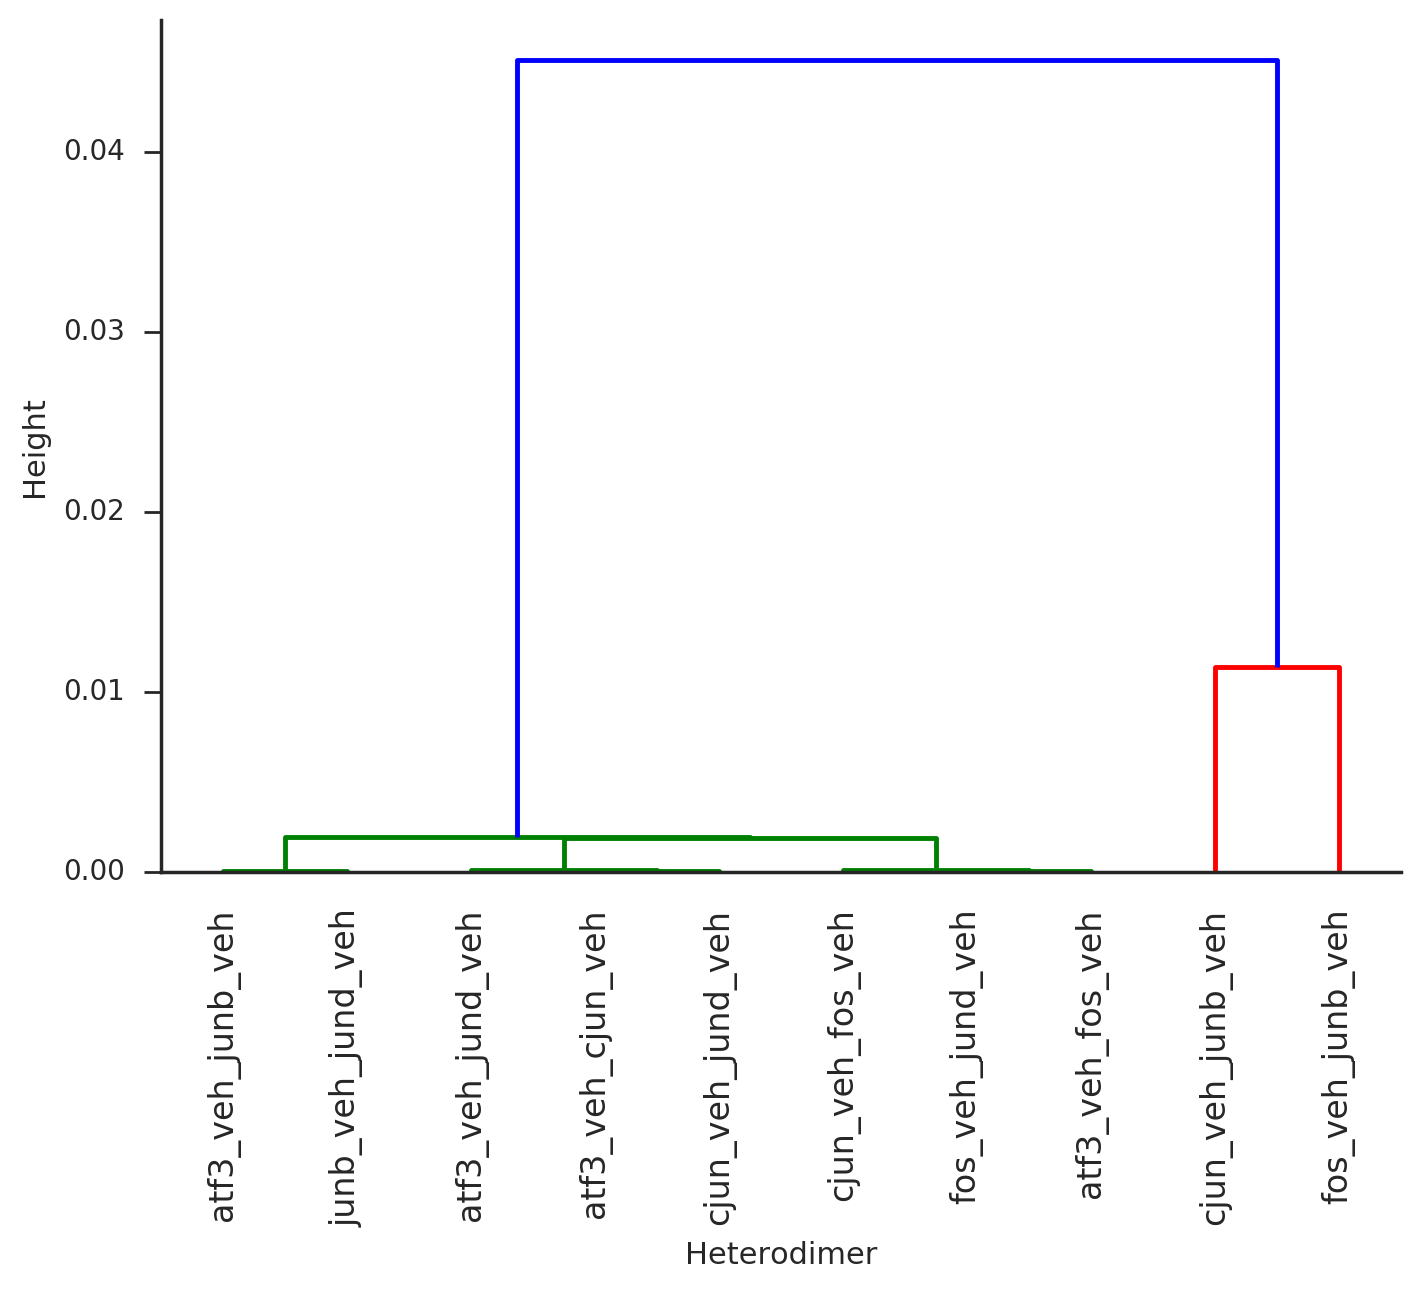

In [88]:
correlations = np.load('./denovo_motif_analysis/top_motifs_veh_overlapping/scores/correlation.npz')['arr_0']

distances = []
for i in range(correlations.shape[0] - 1):
    for j in range(i + 1, correlations.shape[0]):
        distances.append( 1 - correlations[i][j])
distances = np.array(distances)

linkage = scipy.cluster.hierarchy.linkage(distances)

with sns.axes_style('ticks'):
    scipy.cluster.hierarchy.dendrogram(linkage, labels = dimers);
    sns.despine()
    plt.xticks(rotation=90)
    plt.xlabel('Heterodimer')
    plt.ylabel('Height')
plt.savefig('./figures/supplementary - overlapping heterodimer motif dendrogram.svg', bbox_inches='tight')

#### Nonoverlapping Heterodimers

In [89]:
!python /home/jtao/code/motif_tools/scoreMotifs.py ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/ ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/scores

Reading motif files...
Calculating alignments between motifs and scoring motifs
Creating visualizations...
Serializing scores... 
correlation should be used for clustering.


In [90]:
dimers = [x.replace('_nonoverlapping.motif','',) for x in os.listdir('./denovo_motif_analysis/top_motifs_veh_nonoverlapping') if '.motif' in x]

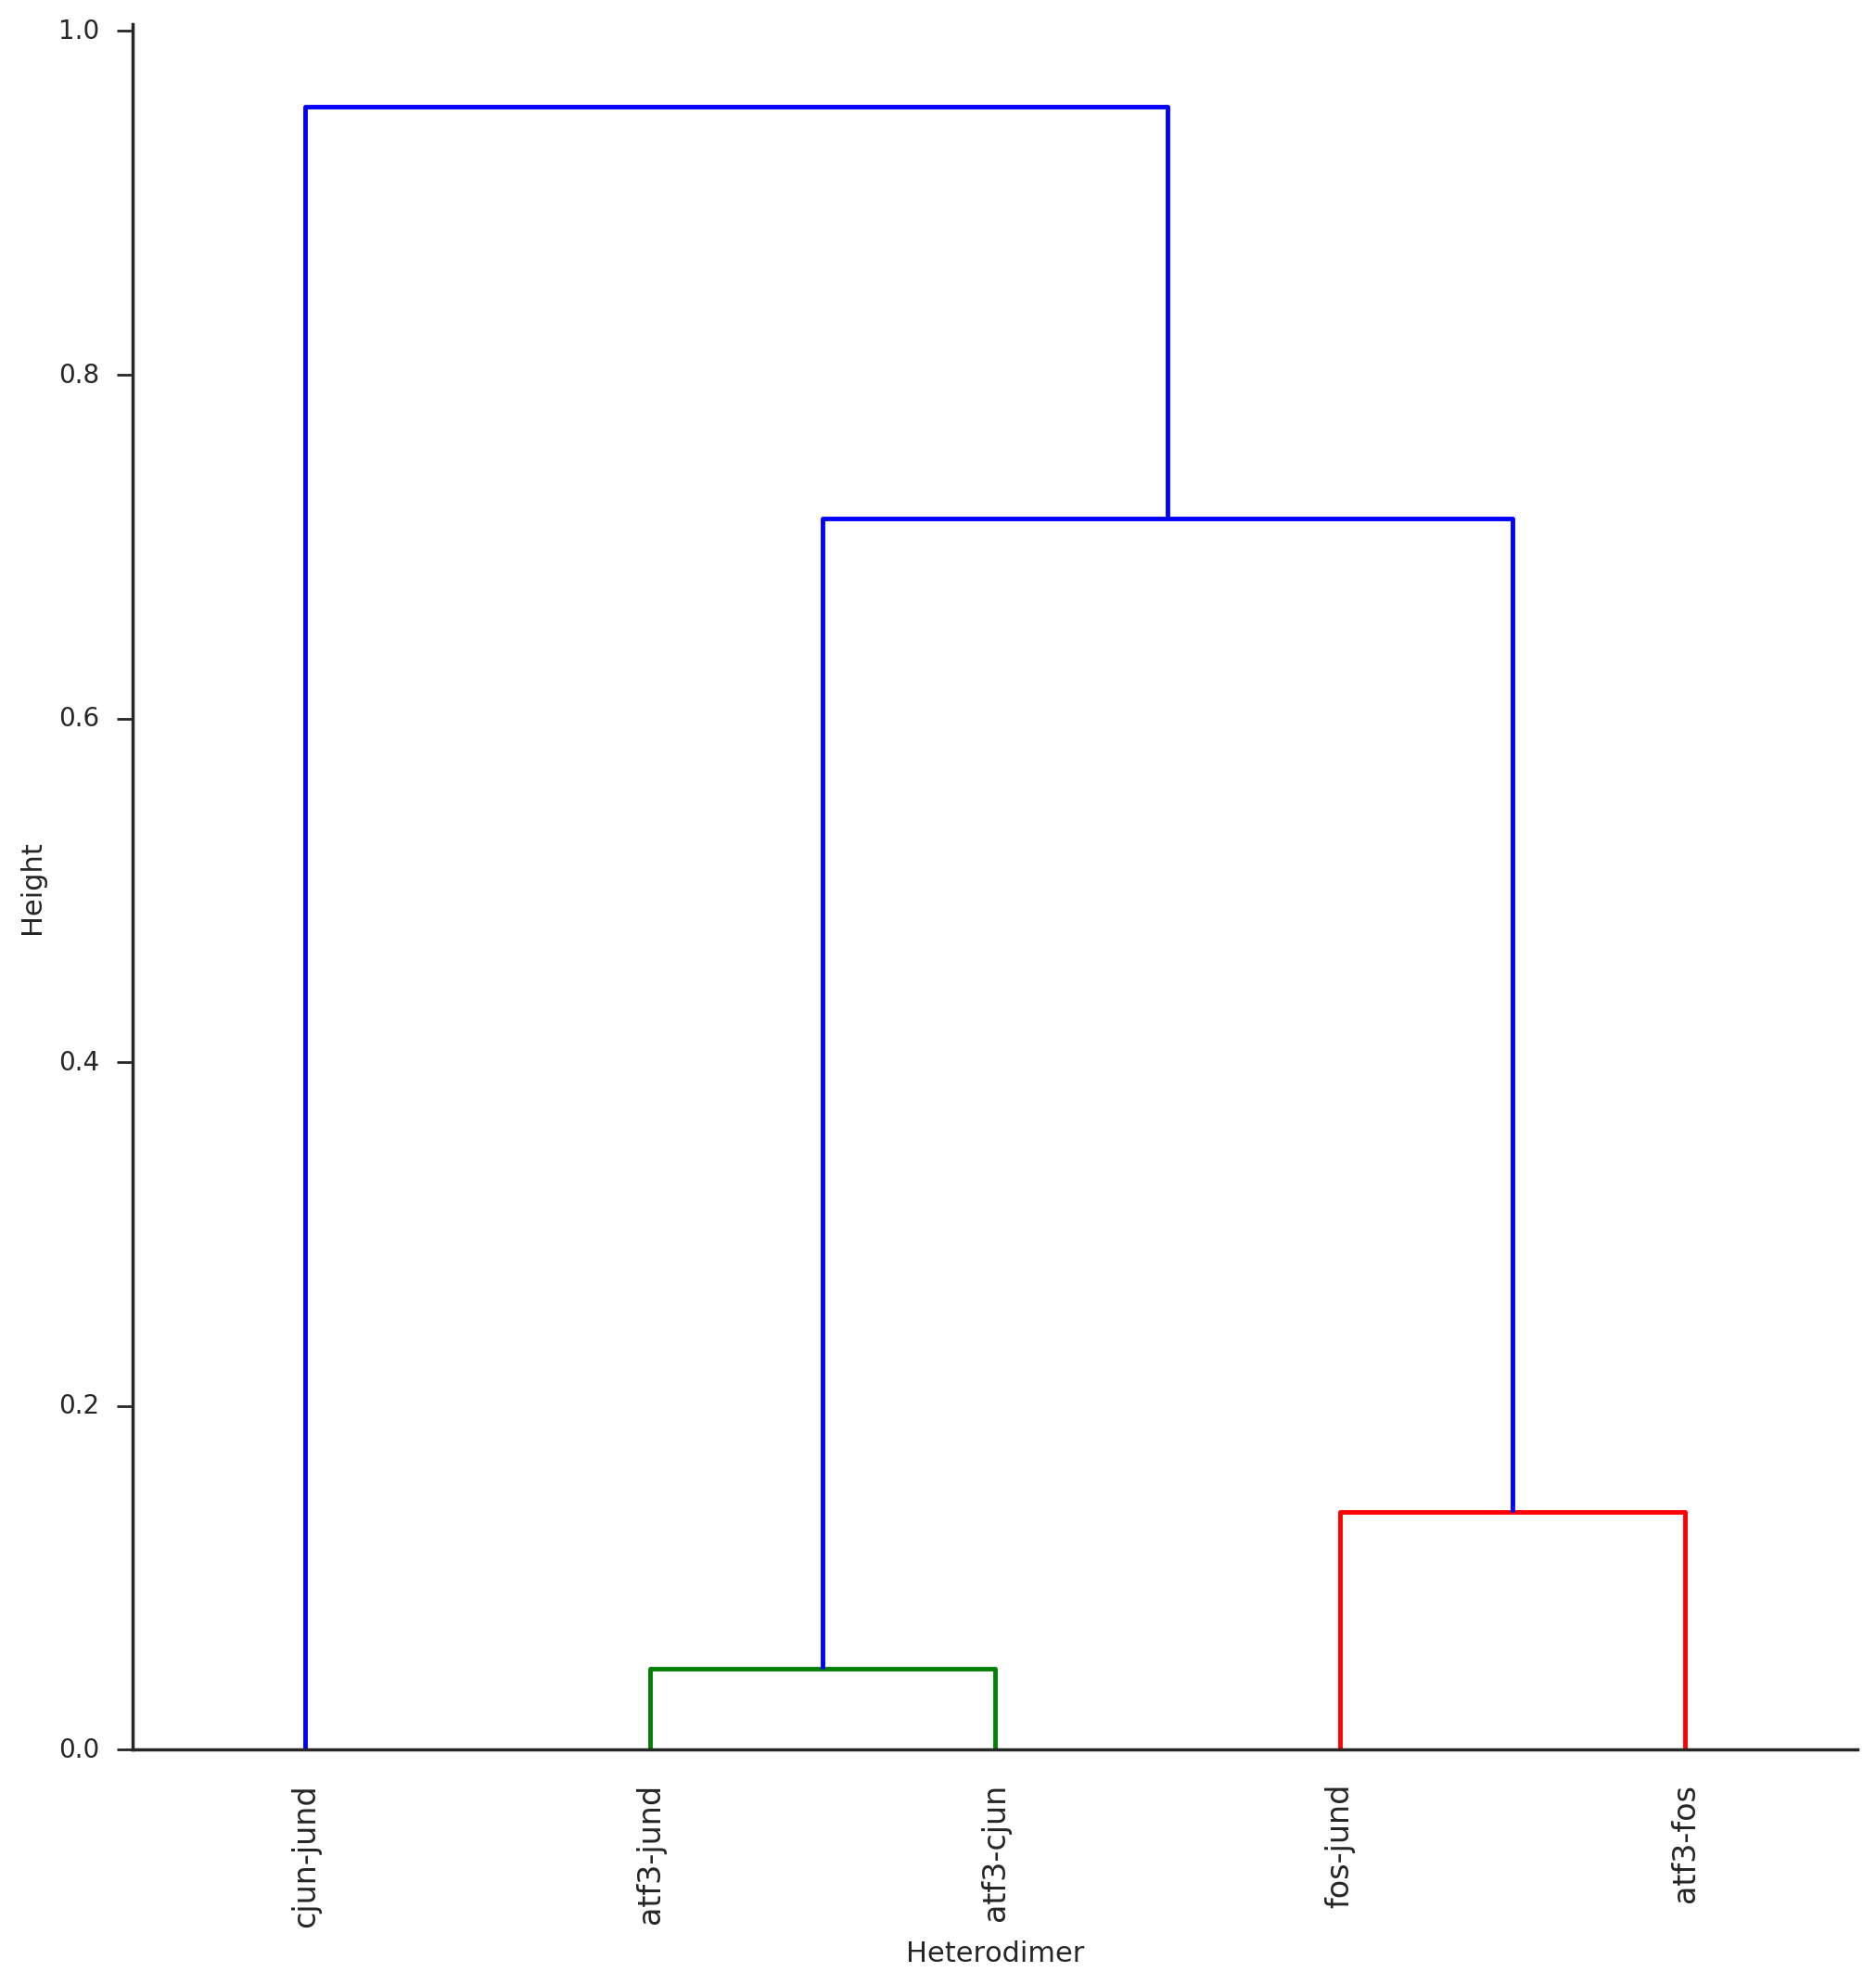

In [91]:

correlations = np.load('./denovo_motif_analysis/top_motifs_veh_nonoverlapping/scores/correlation.npz')['arr_0']

distances = []
for i in range(correlations.shape[0] - 1):
    for j in range(i + 1, correlations.shape[0]):
        distances.append( 1 - correlations[i][j])
distances = np.array(distances)

linkage = scipy.cluster.hierarchy.linkage(distances)


plt.figure(figsize=(12,12))
with sns.axes_style('ticks'):
    scipy.cluster.hierarchy.dendrogram(linkage, labels = dimers);
    sns.despine()
    plt.xticks(rotation=90)
    plt.xlabel('Heterodimer')
    plt.ylabel('Height')
    plt.savefig('./figures/supplementary - nonoverlapping heterodimer motif dendrogram.svg', bbox_inches='tight')

### Stacked bar plot of known motif ranks

In [92]:
motif_dir = './denovo_motif_analysis/veh_motif_analysis_overlapping/'
p_threshold = 0.01
numMotifs = 5
motif_rank_count_dict = {} # {motif: {rank:count}}
for p in os.listdir(motif_dir):
    tokens = p.split('_')
    if len(tokens) > 2:
        current_frame = pd.read_csv(motif_dir + p + '/knownResults.txt', sep='\t')
        current_significant_frame = current_frame[current_frame['P-value'].astype(float) < p_threshold]
        if current_frame.shape[0] >= numMotifs:
            top_motifs = current_significant_frame.ix[:numMotifs-1,'Motif Name'].values
            
            for i in range(len(top_motifs)):
                motif = top_motifs[i]
                if not motif in motif_rank_count_dict:
                    motif_rank_count_dict[motif] = {x+1:0 for x in range(numMotifs)} # initialize dictionary
                motif_rank_count_dict[motif][i+1] += 1
        else:
            print(p, 'is missing motifs')
sorted_motifs = sorted(motif_rank_count_dict.keys())

rank_dict = {x+1:[] for x in range(numMotifs)} # {rank:count} create dictionary for creating data frame, sorted_motifs will be index
for motif in sorted_motifs:
    for i in range(numMotifs):
        rank_dict[i + 1].append(motif_rank_count_dict[motif][i+1])
motif_rank_frame = pd.DataFrame(rank_dict)
motif_rank_frame.index = sorted_motifs
# clean up motif names
motif_rank_frame.index = [x.split('-ChIP')[0] for x in motif_rank_frame.index.values]

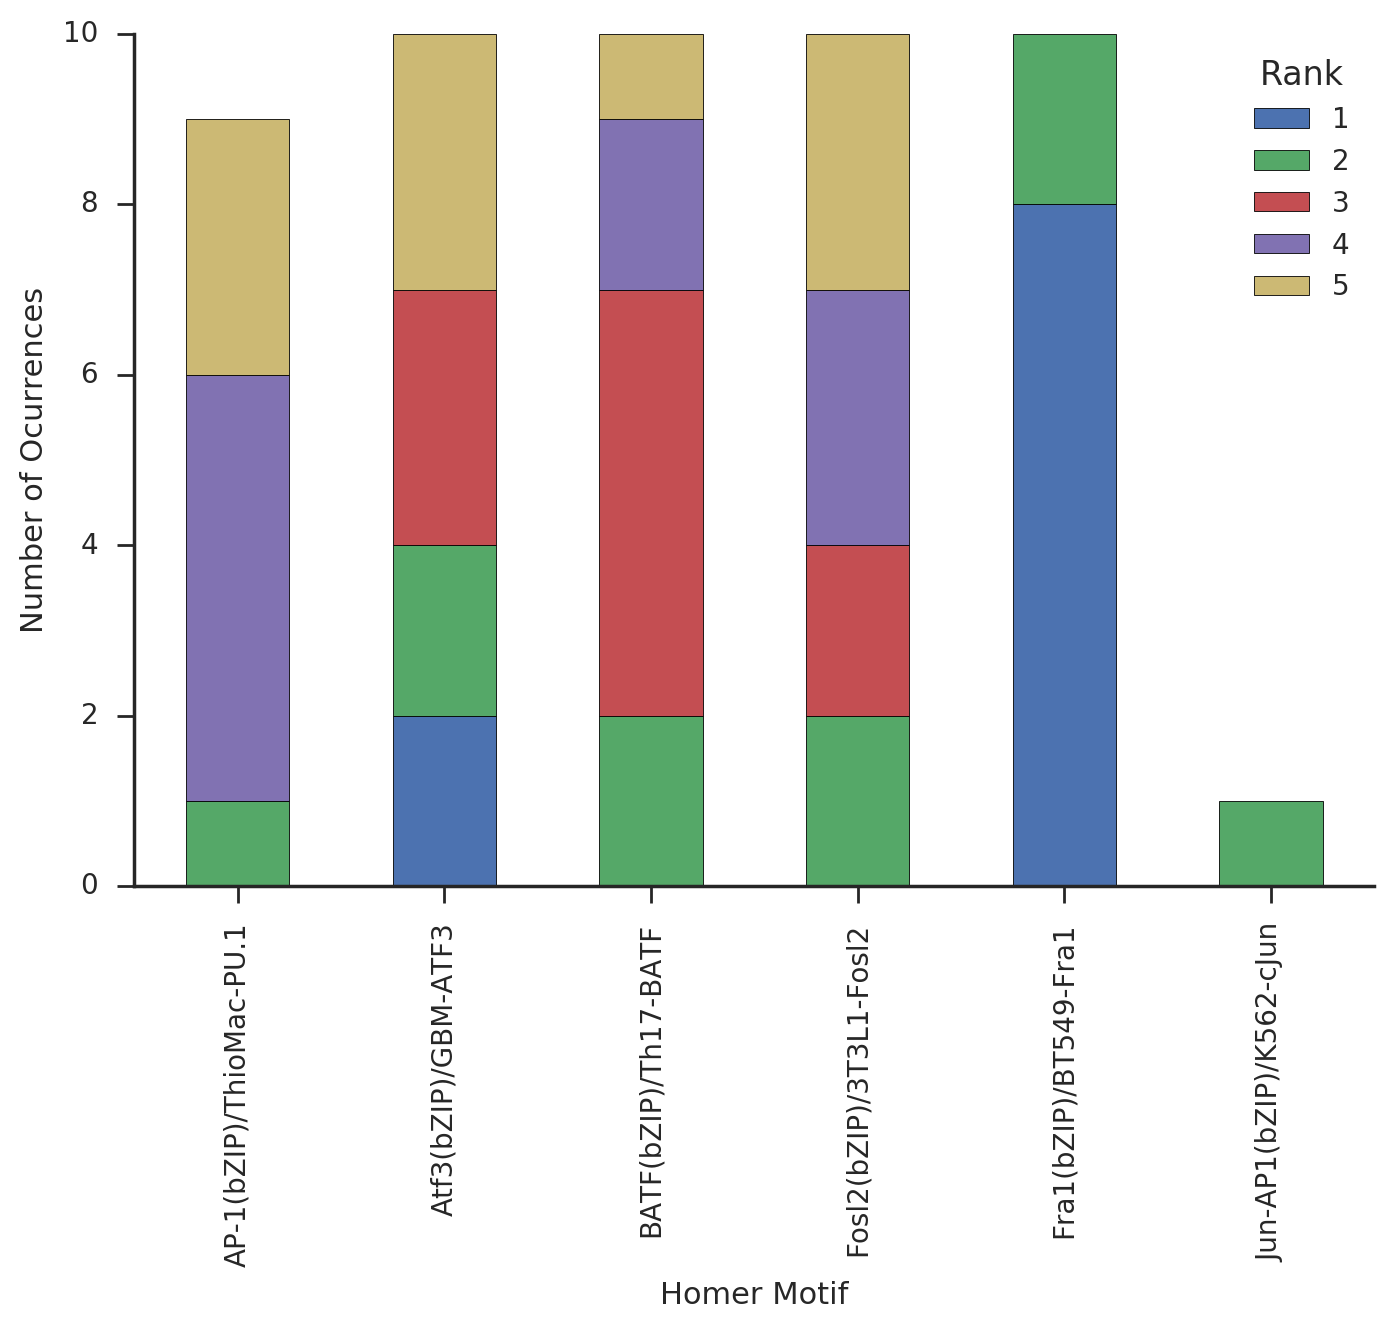

In [93]:
with sns.axes_style('ticks'):
    motif_rank_frame.plot(kind='bar', stacked=True)
    sns.despine()
    plt.legend(title='Rank')
    plt.ylabel('Number of Ocurrences')
    plt.xlabel('Homer Motif')
    plt.savefig('./figures/figure_02_b.svg', bbox_inches='tight')

# Figure 3 - Machine Learning Overview

### Schematic of classifier workflow

## Figure 4 - Motifs for Vehicle Dimers

In [3]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']

In [94]:
### for all peaks in vehicle for all motifs
strain = 'c57bl6'
factor_coeff_dict_veh = {}
factor_auc_dict_veh = {}
factor_precision_dict_veh = {}
for treatment in ['veh']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        all_aucs = []
        all_coefficients = []
        all_precisions = []

        for i in range(numIterations):  
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            current_coefficients = affinity_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)

        factor_auc_dict_veh[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_veh[monomer + '_' + treatment] = all_precisions
        factor_coeff_dict_veh[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.950166206909 7.14135716666e-07 precision: 0.947924620686 1.07625016037e-06 numTestPositives: 11073
cjun_veh roc: 0.955692989653 2.18274915938e-06 precision: 0.954743927898 2.31365694555e-06 numTestPositives: 6363
fos_veh roc: 0.953059766473 8.46178905934e-06 precision: 0.951832797237 1.88223340684e-05 numTestPositives: 999
junb_veh roc: 0.806645096254 0.000280186630629 precision: 0.816680728065 0.000333656219935 numTestPositives: 248
jund_veh roc: 0.949305993686 1.51449081212e-06 precision: 0.947541453545 2.24161467909e-06 numTestPositives: 9071


In [95]:
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict_veh)
coefficients_frame_veh.index = standardized_motif_frame.columns.values

# transform_coffcients into z-scores
coefficients_zscore_frame_veh = coefficients_frame_veh[[]]
for col in coefficients_frame_veh:
    coefficients_zscore_frame_veh[col] = scipy.stats.mstats.zscore(coefficients_frame_veh[col].values)

coefficients_zscore_frame_veh.index = coefficients_frame_veh.index.values
coefficients_zscore_frame_veh.columns = coefficients_frame_veh.columns.values



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [83]:
### for all peaks in vehicle for AP-1 motifs
strain = 'c57bl6'
factor_auc_dict_veh_ap1 = {}
factor_precision_dict_veh_ap1 = {}
for treatment in ['veh']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)][['ap-1','atf7_batf3_creb5']]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)][['ap-1','atf7_batf3_creb5']]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):          
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_dict_veh_ap1[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_veh_ap1[monomer + '_' + treatment] = all_precisions
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.713550154896 1.56531893711e-06 precision: 0.686517196121 9.99568900076e-06 numTestPositives: 11073
cjun_veh roc: 0.735691477592 6.63749222731e-06 precision: 0.699952421361 5.22475476525e-06 numTestPositives: 6363
fos_veh roc: 0.611437062688 6.33746688408e-05 precision: 0.601091504441 8.13773617004e-05 numTestPositives: 999
junb_veh roc: 0.601186914672 0.000385075755586 precision: 0.595107783058 0.000533095089751 numTestPositives: 248
jund_veh roc: 0.690729493092 2.58947400614e-06 precision: 0.664578895387 9.78940515568e-06 numTestPositives: 9071


In [124]:
### for all peaks in vehicle for top motifs
strain = 'c57bl6'
weight_threshold = 1.25
factor_coeff_dict_veh_top = {}
factor_auc_dict_veh_top = {}
factor_precision_dict_veh_top = {}
for treatment in ['veh']:
    for monomer in ap1_members:
        # determine top motifs
        data = coefficients_zscore_frame_veh
        top_motifs = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ].index.values
        print(len(top_motifs))
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)][top_motifs]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)][top_motifs]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_dict_veh_top[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_veh_top[monomer + '_' + treatment] = all_precisions
        factor_coeff_dict_veh_top[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

33


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


atf3_veh roc: 0.8824367975 2.41587442433e-06 precision: 0.874924247608 4.92672056961e-06 numTestPositives: 11073
33
cjun_veh roc: 0.88438310098 1.84510872553e-06 precision: 0.879573755588 4.71848707489e-06 numTestPositives: 6363
13
fos_veh roc: 0.8997664331 1.53432680339e-05 precision: 0.891230076327 6.654047242e-05 numTestPositives: 999
44
junb_veh roc: 0.826105619147 0.000357022645025 precision: 0.837287569906 0.000261460460613 numTestPositives: 248
37
jund_veh roc: 0.860640568693 1.66005534225e-06 precision: 0.858446961527 3.50219502922e-06 numTestPositives: 9071


In [89]:
### for all peaks in vehicle for all non AP-1 motifs
strain = 'c57bl6'
factor_coeff_dict_veh_nonAP1 = {}
factor_auc_dict_veh_nonAP1 = {}
factor_precision_dict_veh_nonAP1 = {}
for treatment in ['veh']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        del affinity_features['ap-1']
        del affinity_features['atf7_batf3_creb5']
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):  
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])

            del training_count_features['ap-1']
            del training_count_features['atf7_batf3_creb5']
            
            del test_count_features['ap-1']
            del test_count_features['atf7_batf3_creb5']
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)


        factor_auc_dict_veh_nonAP1[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_veh_nonAP1[monomer + '_' + treatment] = all_precisions
        factor_coeff_dict_veh_nonAP1[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


atf3_veh roc: 0.946475948401 2.63864145531e-06 precision: 0.94469594247 3.3619384162e-06 numTestPositives: 11073
cjun_veh roc: 0.952950153909 3.38488944386e-06 precision: 0.953708129426 3.32874990959e-06 numTestPositives: 6363
fos_veh roc: 0.938948758568 1.55451427222e-05 precision: 0.940983239759 1.44142036165e-05 numTestPositives: 999
junb_veh roc: 0.794681646722 0.000130408903889 precision: 0.806888013812 0.000336496454511 numTestPositives: 248
jund_veh roc: 0.946598795492 3.06496717248e-06 precision: 0.945254619293 4.36854850466e-06 numTestPositives: 9071


### Classifier Performance

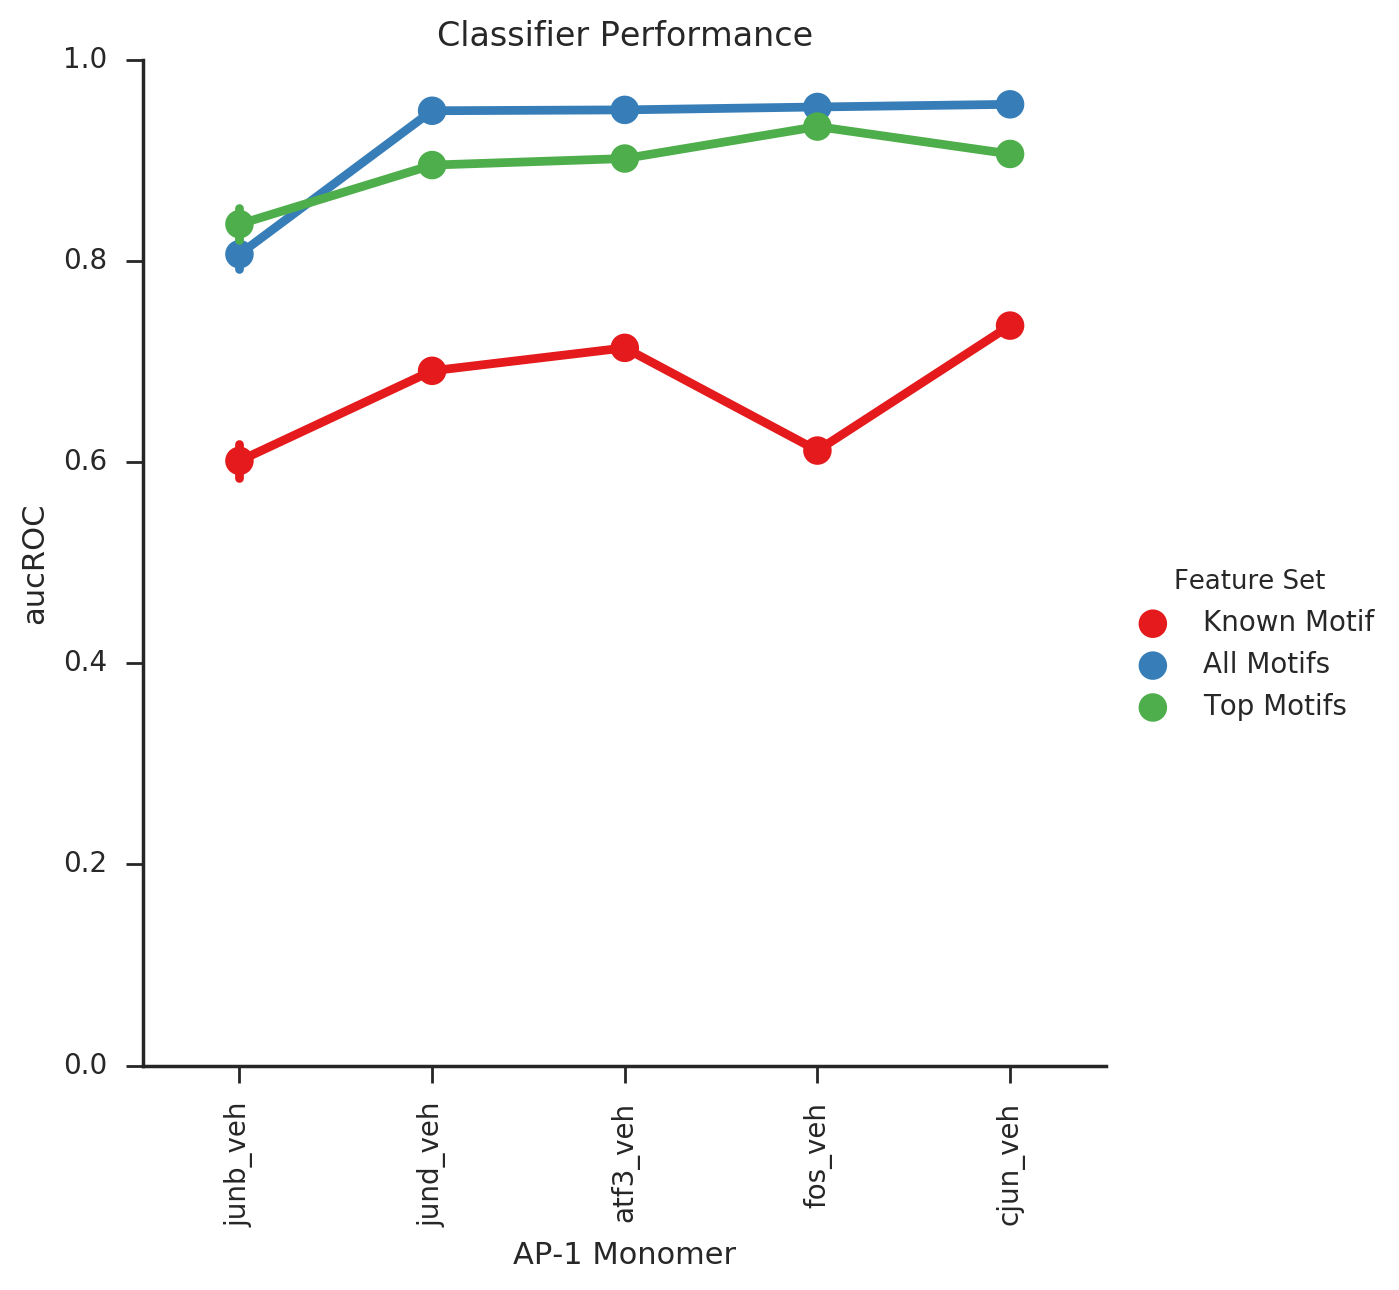

In [98]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_dict_veh.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_veh_ap1[factor]
    feature_set = feature_set + numIterations * ['Known Motif']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_veh[factor]
    feature_set = feature_set + numIterations * ['All Motifs']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_veh_top[factor]
    feature_set = feature_set + numIterations * ['Top Motifs']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

for treatment in ['veh']:
    factor_auc_tuples = [(x, np.mean(factor_auc_dict_veh[x])) for x in factor_auc_dict_veh if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'point')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_04_a.svg')
        plt.show()

    

### Distribution of Motif Weights (for cjun-fos, or all dimers?)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


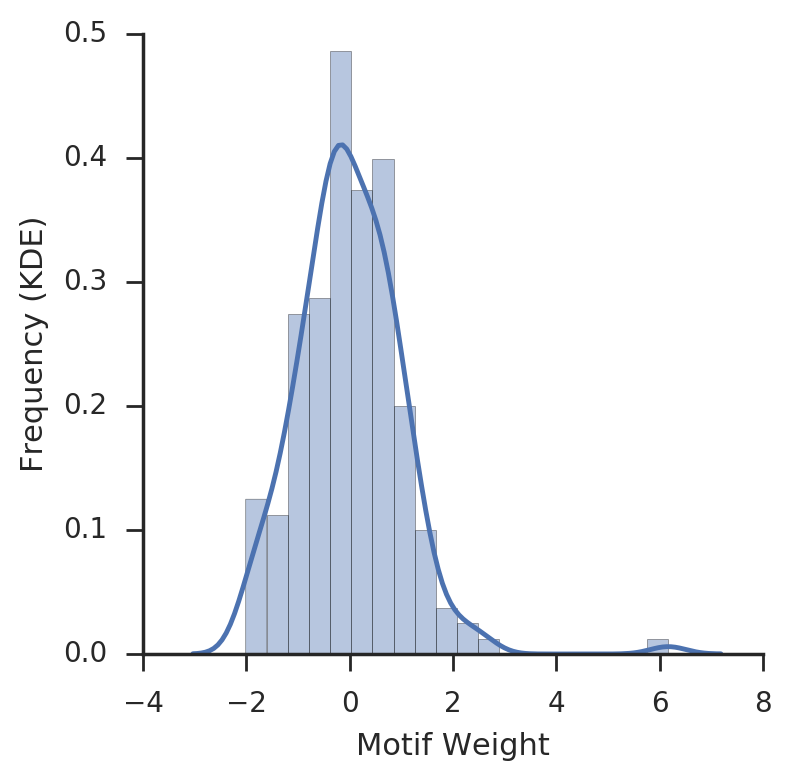

In [103]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.distplot(coefficients_zscore_frame_veh['cjun_veh'])
    sns.despine()
    plt.xlabel('Motif Weight')
    plt.ylabel('Frequency (KDE)')
plt.savefig('./figures/figure_04_b.svg', bbox_inches='tight')

### Scatter plot for similar dimers

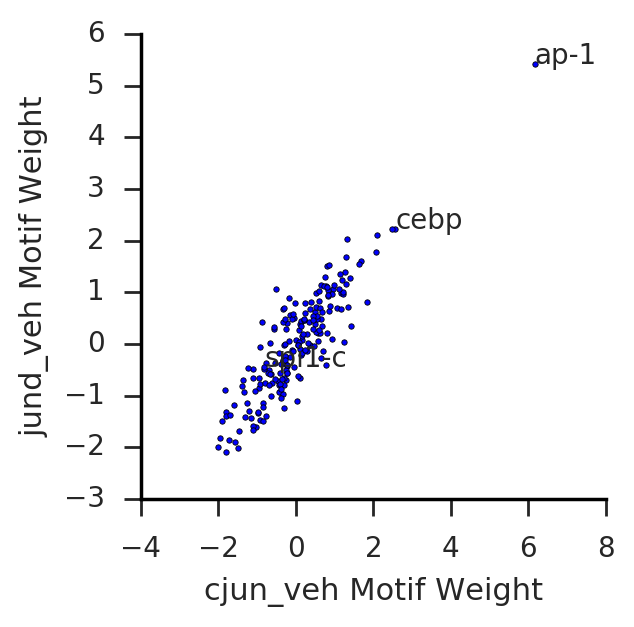

In [110]:
# scatterplot of weights
factor1 = 'cjun_veh'
factor2 = 'jund_veh'
delta_threshold = 2.0
targets = ['ap-1', 'cebp', 'spi1-c']
plt.figure(figsize=(3,3))
motifs = coefficients_zscore_frame_veh.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_zscore_frame_veh[factor1]
    y_vals = coefficients_zscore_frame_veh[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if (abs(x) >= 0.5) or (abs(y) >= 0.5)  or (motifs[i] in targets):
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if (delta > delta_threshold) or (motifs[i] in targets):
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_c.svg', bbox_inches='tight')

### Scatter plot for dissimilar dimers

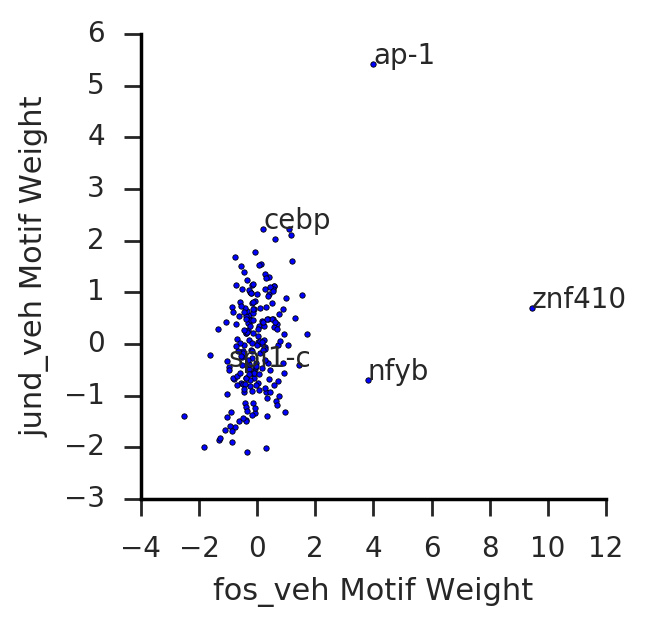

In [115]:
# scatterplot of weights
factor1 = 'fos_veh'
factor2 = 'jund_veh'
delta_threshold = 3.0
targets = ['ap-1', 'cebp', 'spi1-c']
plt.figure(figsize=(3,3))
motifs = coefficients_zscore_frame_veh.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_zscore_frame_veh[factor1]
    y_vals = coefficients_zscore_frame_veh[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if delta > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_d.svg', bbox_inches='tight')


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


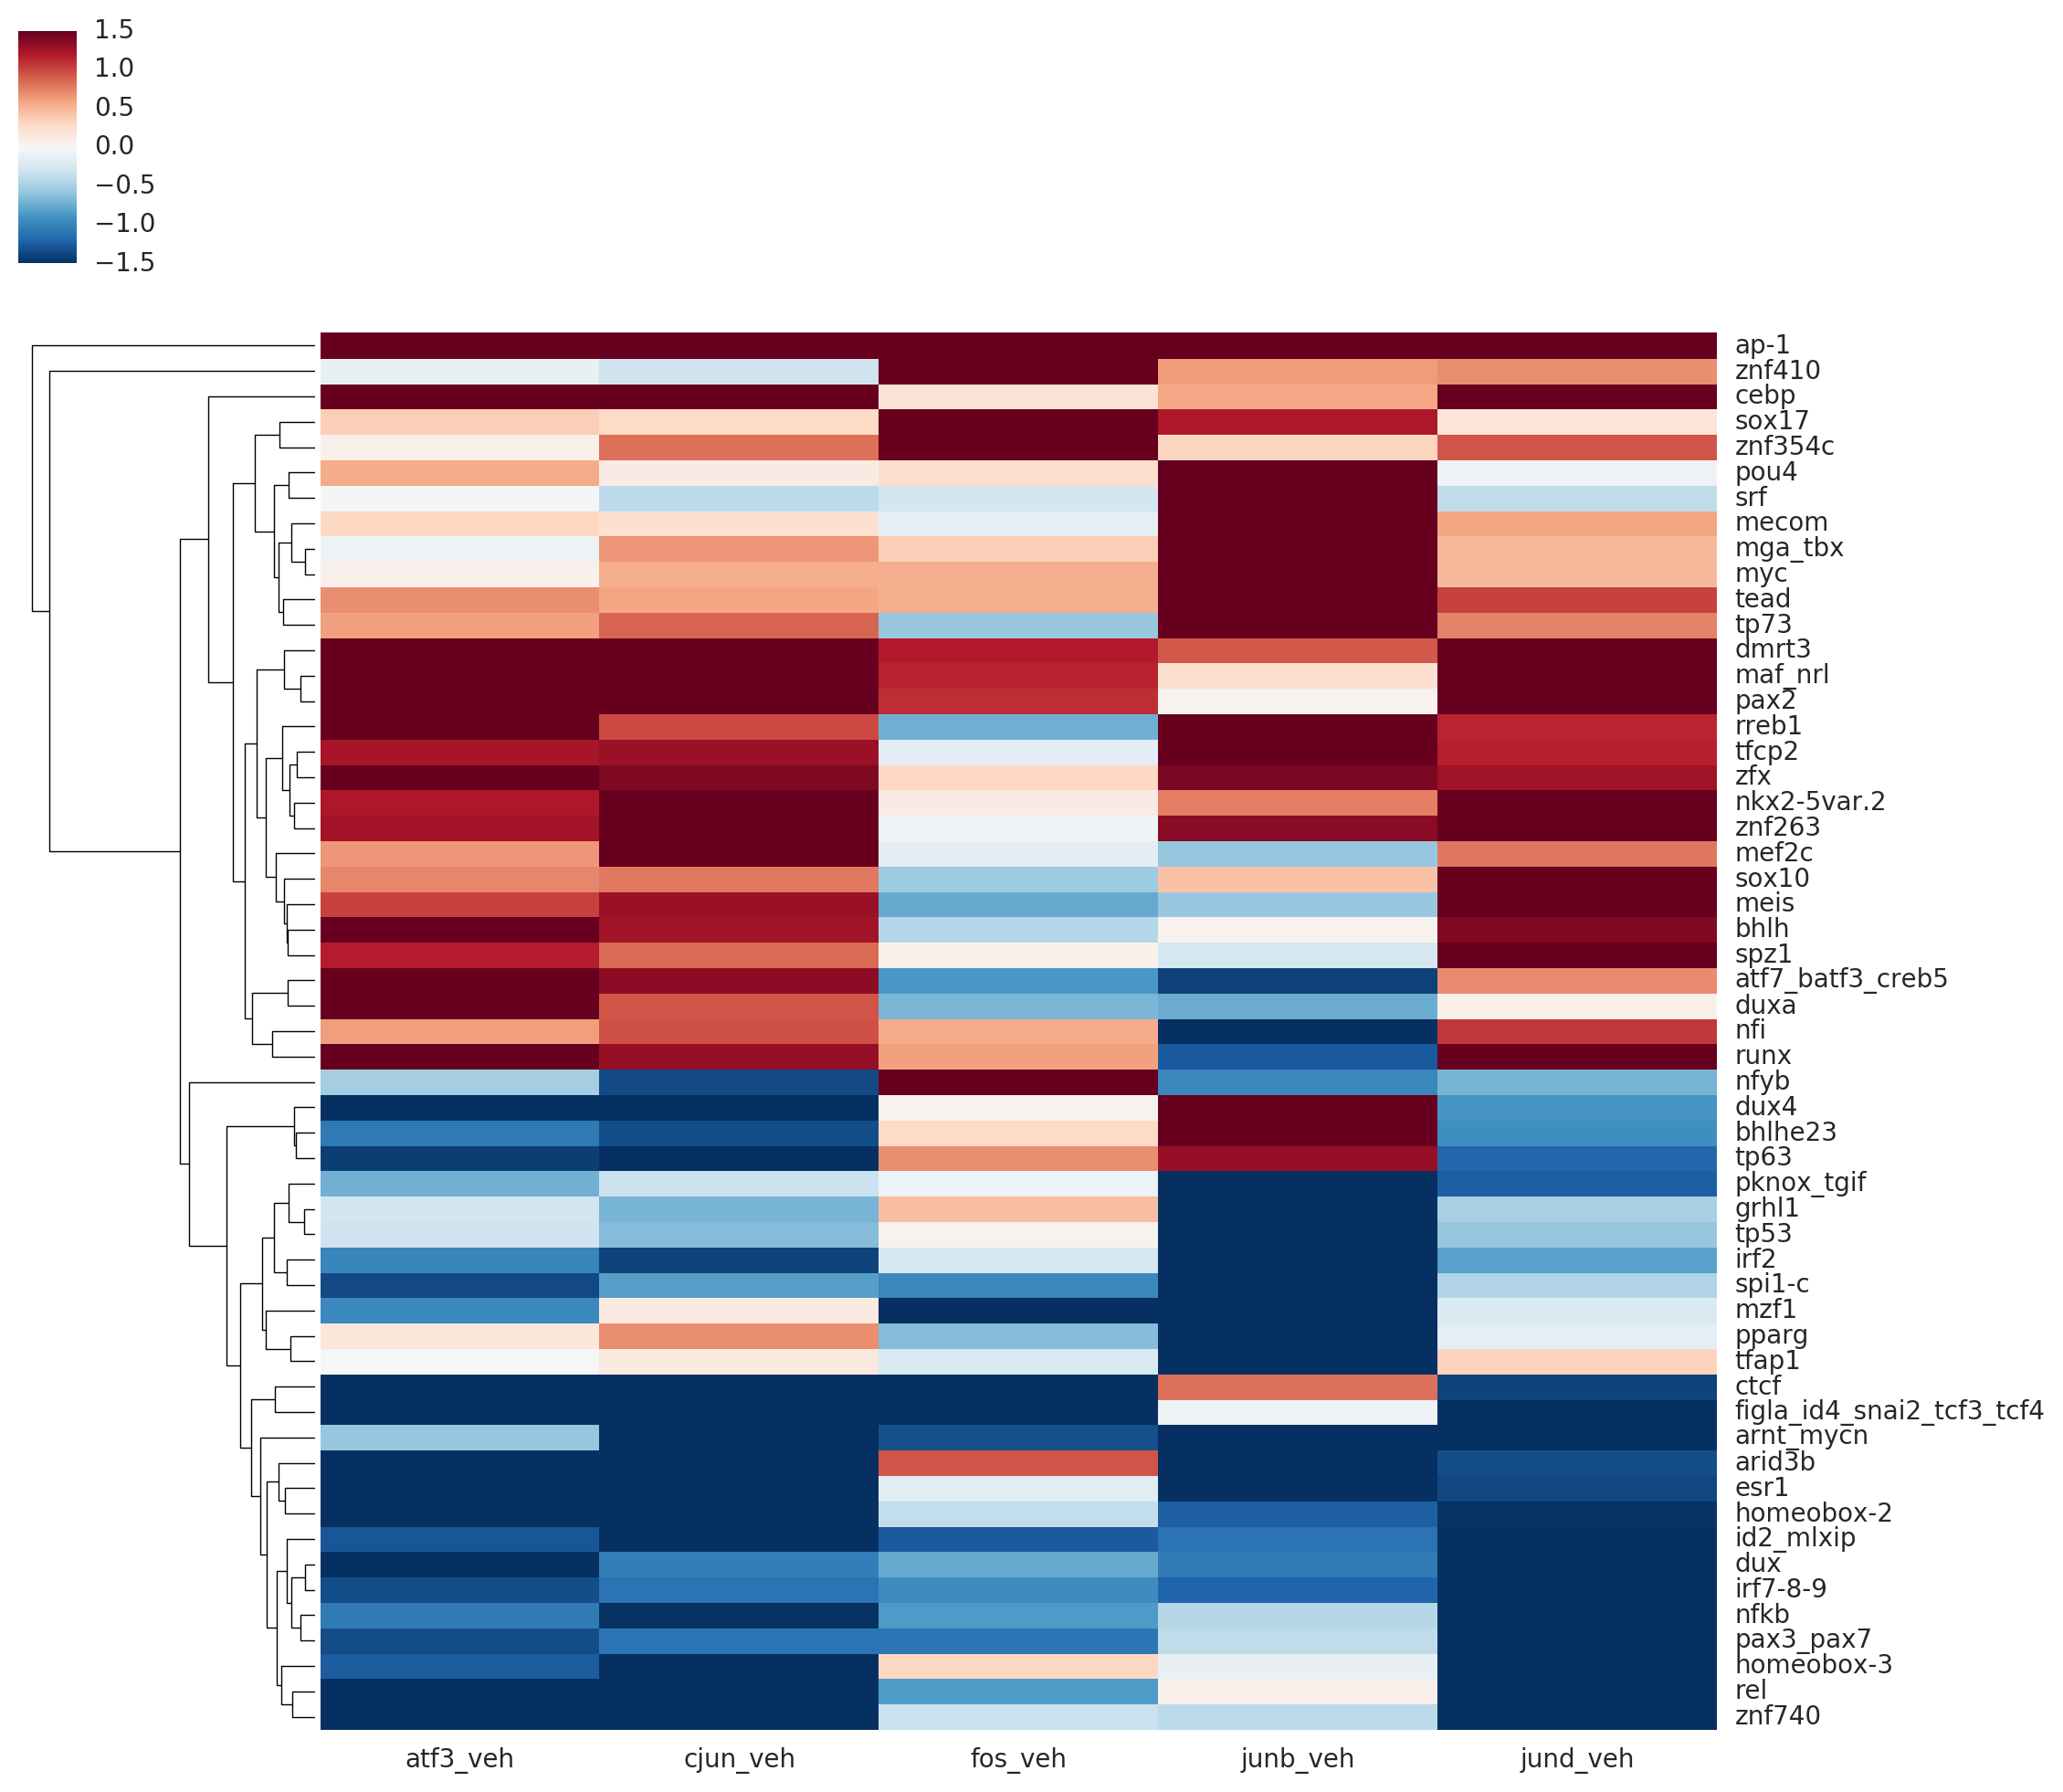

In [126]:
### plot coefficents for vehicle
weight_threshold = 1.5

cg = sns.clustermap(coefficients_zscore_frame_veh[(coefficients_zscore_frame_veh.max(axis=1) >= weight_threshold) |
                                       (coefficients_zscore_frame_veh.min(axis=1) < -1 * weight_threshold)
                                      ],
                   vmax=-1*weight_threshold,
                   vmin= 1* weight_threshold,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   col_cluster = False,
#                    yticklabels=False,
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_zscore_frame_veh.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );
plt.savefig('./figures/figure_04_e.svg', bbox_inches='tight')

# Figure 5 - Context Change after KLA treatment

In [218]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']

In [127]:
### for all peaks in KLA for all motifs
strain = 'c57bl6'
factor_coeff_dict_kla = {}
factor_auc_dict_kla = {}
factor_precision_dict_kla = {}
for treatment in ['kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        all_aucs = []
        all_coefficients = []
        all_precisions = []

        for i in range(numIterations):  
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            current_coefficients = affinity_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)

        factor_auc_dict_kla[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_kla[monomer + '_' + treatment] = all_precisions
        factor_coeff_dict_kla[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_kla roc: 0.947423387407 1.6496606522e-06 precision: 0.944086092086 2.573585565e-06 numTestPositives: 17428
cjun_kla roc: 0.956781336759 1.05874726715e-06 precision: 0.954351453844 1.12521184237e-06 numTestPositives: 8108
fos_kla roc: 0.963875142635 1.13930051732e-06 precision: 0.961445573831 1.40957145713e-06 numTestPositives: 9628
junb_kla roc: 0.96380107671 1.00457106347e-06 precision: 0.962491947531 1.64424769044e-06 numTestPositives: 7068
jund_kla roc: 0.950319169697 7.6175170093e-07 precision: 0.946733264369 1.19547896125e-06 numTestPositives: 15061


In [129]:
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict_kla)
coefficients_frame_kla.index = standardized_motif_frame.columns.values

# transform_coffcients into z-scores
coefficients_zscore_frame_kla = coefficients_frame_kla[[]]
for col in coefficients_frame_kla:
    coefficients_zscore_frame_kla[col] = scipy.stats.mstats.zscore(coefficients_frame_kla[col].values)

coefficients_zscore_frame_kla.index = coefficients_frame_kla.index.values
coefficients_zscore_frame_kla.columns = coefficients_frame_kla.columns.values


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [128]:
### for all peaks in KLA for AP-1 motifs
strain = 'c57bl6'
factor_auc_dict_kla_ap1 = {}
factor_precision_dict_kla_ap1 = {}
for treatment in ['kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)][['ap-1','atf7_batf3_creb5']]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)][['ap-1','atf7_batf3_creb5']]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):          
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][['ap-1','atf7_batf3_creb5']]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_dict_kla_ap1[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_kla_ap1[monomer + '_' + treatment] = all_precisions
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_kla roc: 0.726495658468 3.37545924279e-06 precision: 0.691170828381 9.73867196017e-06 numTestPositives: 17428
cjun_kla roc: 0.746167799093 4.91800475857e-06 precision: 0.70954336224 4.92915247878e-06 numTestPositives: 8108
fos_kla roc: 0.770632457843 1.14835194415e-05 precision: 0.711596100172 1.73522519871e-05 numTestPositives: 9628
junb_kla roc: 0.765575730258 5.31058929953e-06 precision: 0.723858037145 1.16355942012e-05 numTestPositives: 7068
jund_kla roc: 0.714125153376 1.44865185506e-06 precision: 0.679061471241 4.02222628323e-06 numTestPositives: 15061


In [130]:
### for all peaks in KLA for top motifs
strain = 'c57bl6'
weight_threshold = 1.25
factor_coeff_dict_kla_top = {}
factor_auc_dict_kla_top = {}
factor_precision_dict_kla_top = {}
for treatment in ['kla']:
    for monomer in ap1_members:
        # determine top motifs
        data = coefficients_zscore_frame_kla
        top_motifs = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ].index.values
        print(len(top_motifs))
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)][top_motifs]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)][top_motifs]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        all_intercepts = []
        for i in range(numIterations):  
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)][top_motifs],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)][top_motifs]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)][top_motifs],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)][top_motifs]])
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        factor_auc_dict_kla_top[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_kla_top[monomer + '_' + treatment] = all_precisions
        factor_coeff_dict_kla_top[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

27


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


atf3_kla roc: 0.873787071043 1.14748885774e-06 precision: 0.865456137794 4.56711491281e-07 numTestPositives: 17428
26
cjun_kla roc: 0.876674216041 8.7236426471e-06 precision: 0.863266260359 1.75665722041e-05 numTestPositives: 8108
22
fos_kla roc: 0.885584552369 1.77324629841e-06 precision: 0.872789996388 2.67661866904e-06 numTestPositives: 9628
26
junb_kla roc: 0.898337017329 8.03458715055e-06 precision: 0.895102579051 1.1697462844e-05 numTestPositives: 7068
32
jund_kla roc: 0.882135533984 1.46166564007e-06 precision: 0.874975306105 1.61708014974e-06 numTestPositives: 15061


In [131]:
### for all peaks in kla for all non AP-1 motifs
strain = 'c57bl6'
factor_coeff_dict_kla_nonAP1 = {}
factor_auc_dict_kla_nonAP1 = {}
factor_precision_dict_kla_nonAP1 = {}
for treatment in ['kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        background_affinity_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        del affinity_features['ap-1']
        del affinity_features['atf7_batf3_creb5']
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):  
            # split data into training and test sets
            training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
                affinity_features, labels, test_size = test_size)

            training_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(training_affinity_features.index.values)].ix[:,3:],
                                                 motif_count_background_frame[motif_count_background_frame.index.isin(training_affinity_features.index.values)].ix[:,3:]])
            test_count_features = pd.concat([motif_count_frame[motif_count_frame.index.isin(test_affinity_features.index.values)].ix[:,3:],
                                             motif_count_background_frame[motif_count_background_frame.index.isin(test_affinity_features.index.values)].ix[:,3:]])

            del training_count_features['ap-1']
            del training_count_features['atf7_batf3_creb5']
            
            del test_count_features['ap-1']
            del test_count_features['atf7_batf3_creb5']
            #  Train affinity classifier
            affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            affinity_classifier.fit(training_affinity_features, training_labels)

            # Train count classifier
            count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            count_classifier.fit(training_count_features, training_labels)

            # train combined classifier
            training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
            training_count_scores = count_classifier.decision_function(training_count_features)
            training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                             'Count':training_count_scores})
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve test probabilities
            test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
            test_count_scores = count_classifier.decision_function(test_count_features)
            test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                       'Count':test_count_scores})
            probas = combined_classifier.predict_proba(test_combined_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)


        factor_auc_dict_kla_nonAP1[monomer + '_' + treatment] = all_aucs
        factor_precision_dict_kla_nonAP1[monomer + '_' + treatment] = all_precisions
        factor_coeff_dict_kla_nonAP1[monomer + '_' + treatment] = np.mean(all_coefficients, axis=0)
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


atf3_kla roc: 0.942633899799 4.30290663539e-06 precision: 0.940975567375 4.78334100766e-06 numTestPositives: 17428
cjun_kla roc: 0.952085564356 7.43946459201e-06 precision: 0.950821198661 9.39355531087e-06 numTestPositives: 8108
fos_kla roc: 0.953431375891 1.77674804094e-06 precision: 0.95306629699 2.18828198081e-06 numTestPositives: 9628
junb_kla roc: 0.957201365328 3.30237115129e-06 precision: 0.956951537417 1.84308441422e-06 numTestPositives: 7068
jund_kla roc: 0.945794555387 1.38455549224e-06 precision: 0.944688100077 1.51132111219e-06 numTestPositives: 15061


### Classifier Performance

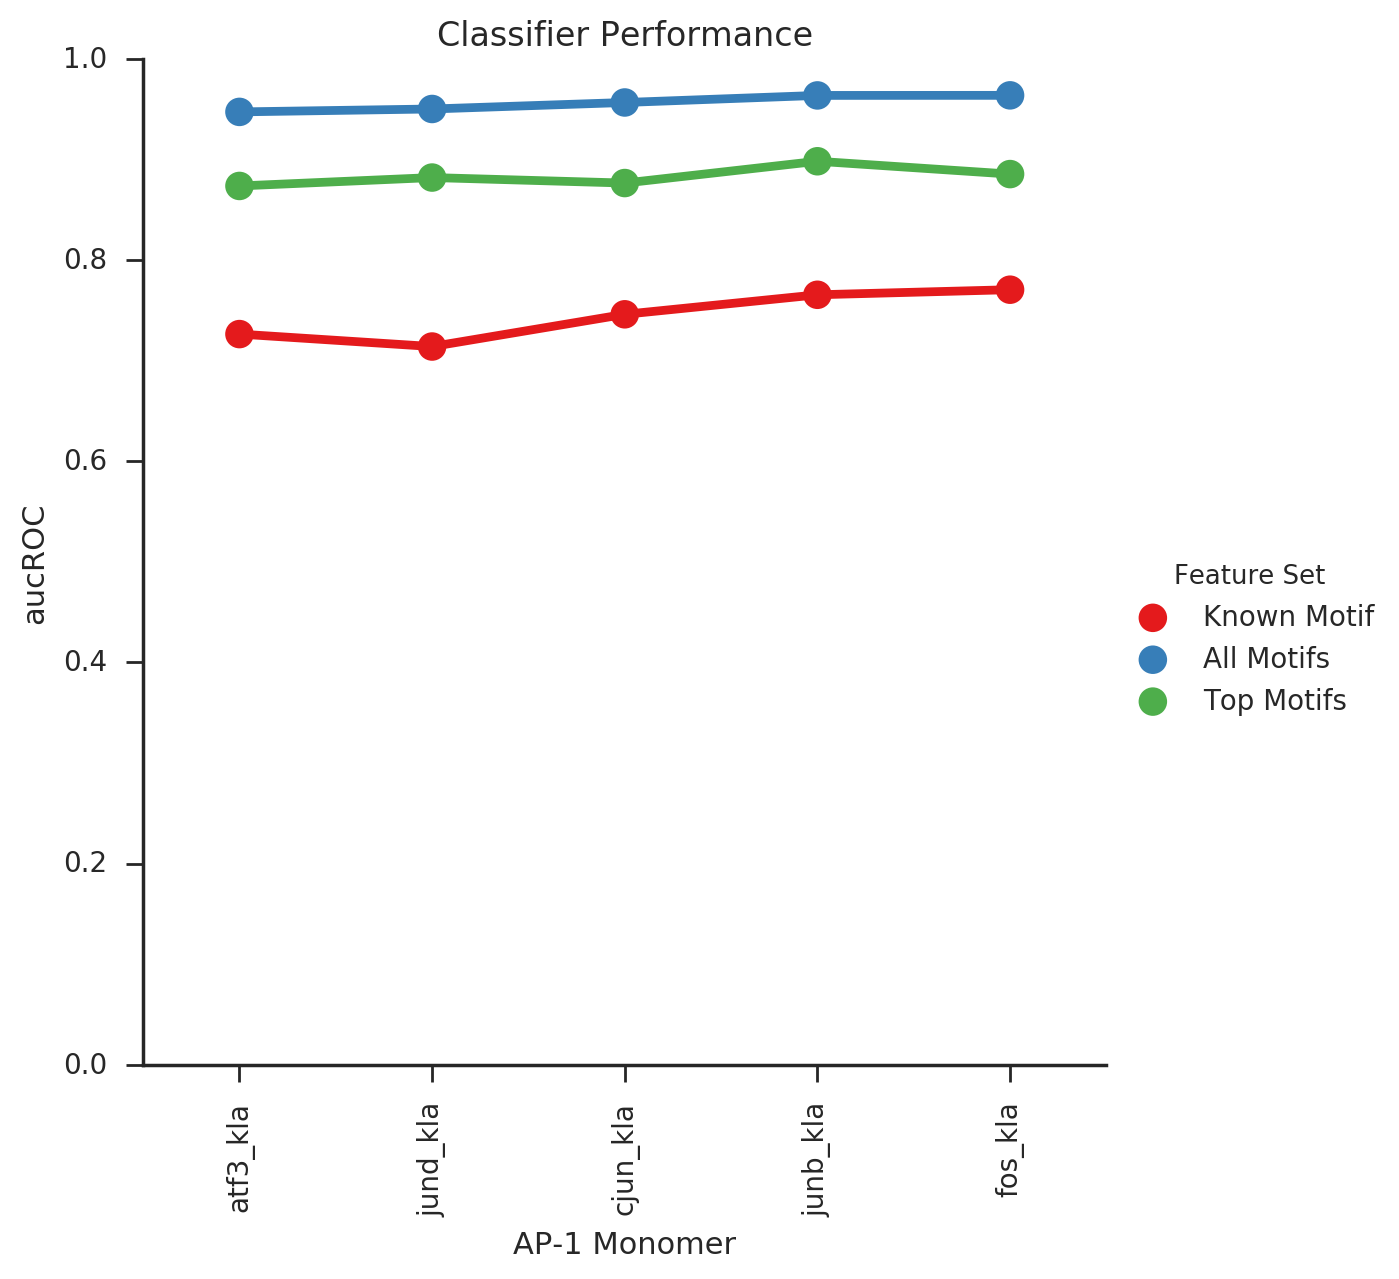

In [132]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_dict_kla.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_kla_ap1[factor]
    feature_set = feature_set + numIterations * ['Known Motif']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_kla[factor]
    feature_set = feature_set + numIterations * ['All Motifs']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_kla_top[factor]
    feature_set = feature_set + numIterations * ['Top Motifs']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

for treatment in ['kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_dict_kla[x])) for x in factor_auc_dict_kla if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=6,
                                    hue='Feature Set',
                                    kind = 'point')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_05_a.svg')
        plt.show()

    

### Scatter plot for all cjun-jund motif weights before and after Vehicle

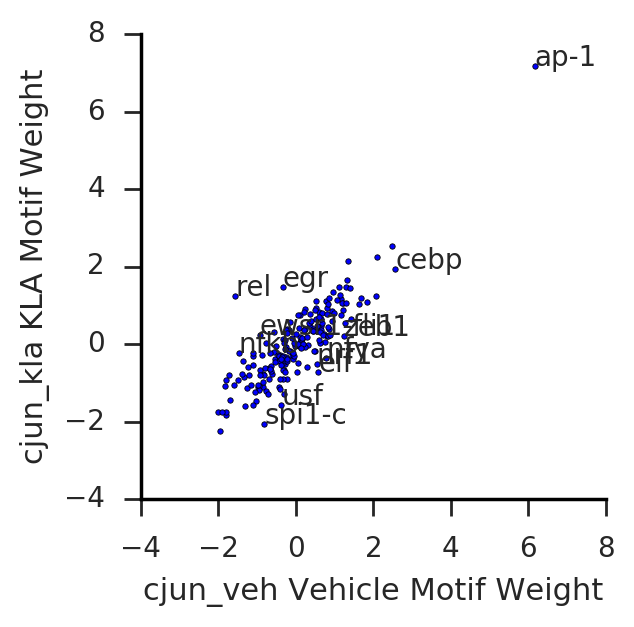

In [203]:
# scatterplot of weights
factor1 = 'cjun_veh'
factor2 = 'cjun_kla'
delta_threshold = 1.0
targets = ['ap-1', 'cebp', 'rel']
# targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_zscore_frame_veh.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_zscore_frame_veh[factor1]
    y_vals = coefficients_zscore_frame_kla[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Vehicle Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' KLA Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if delta > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_05_b.svg', bbox_inches='tight')


### Heatmap for all KLA dimer weights

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


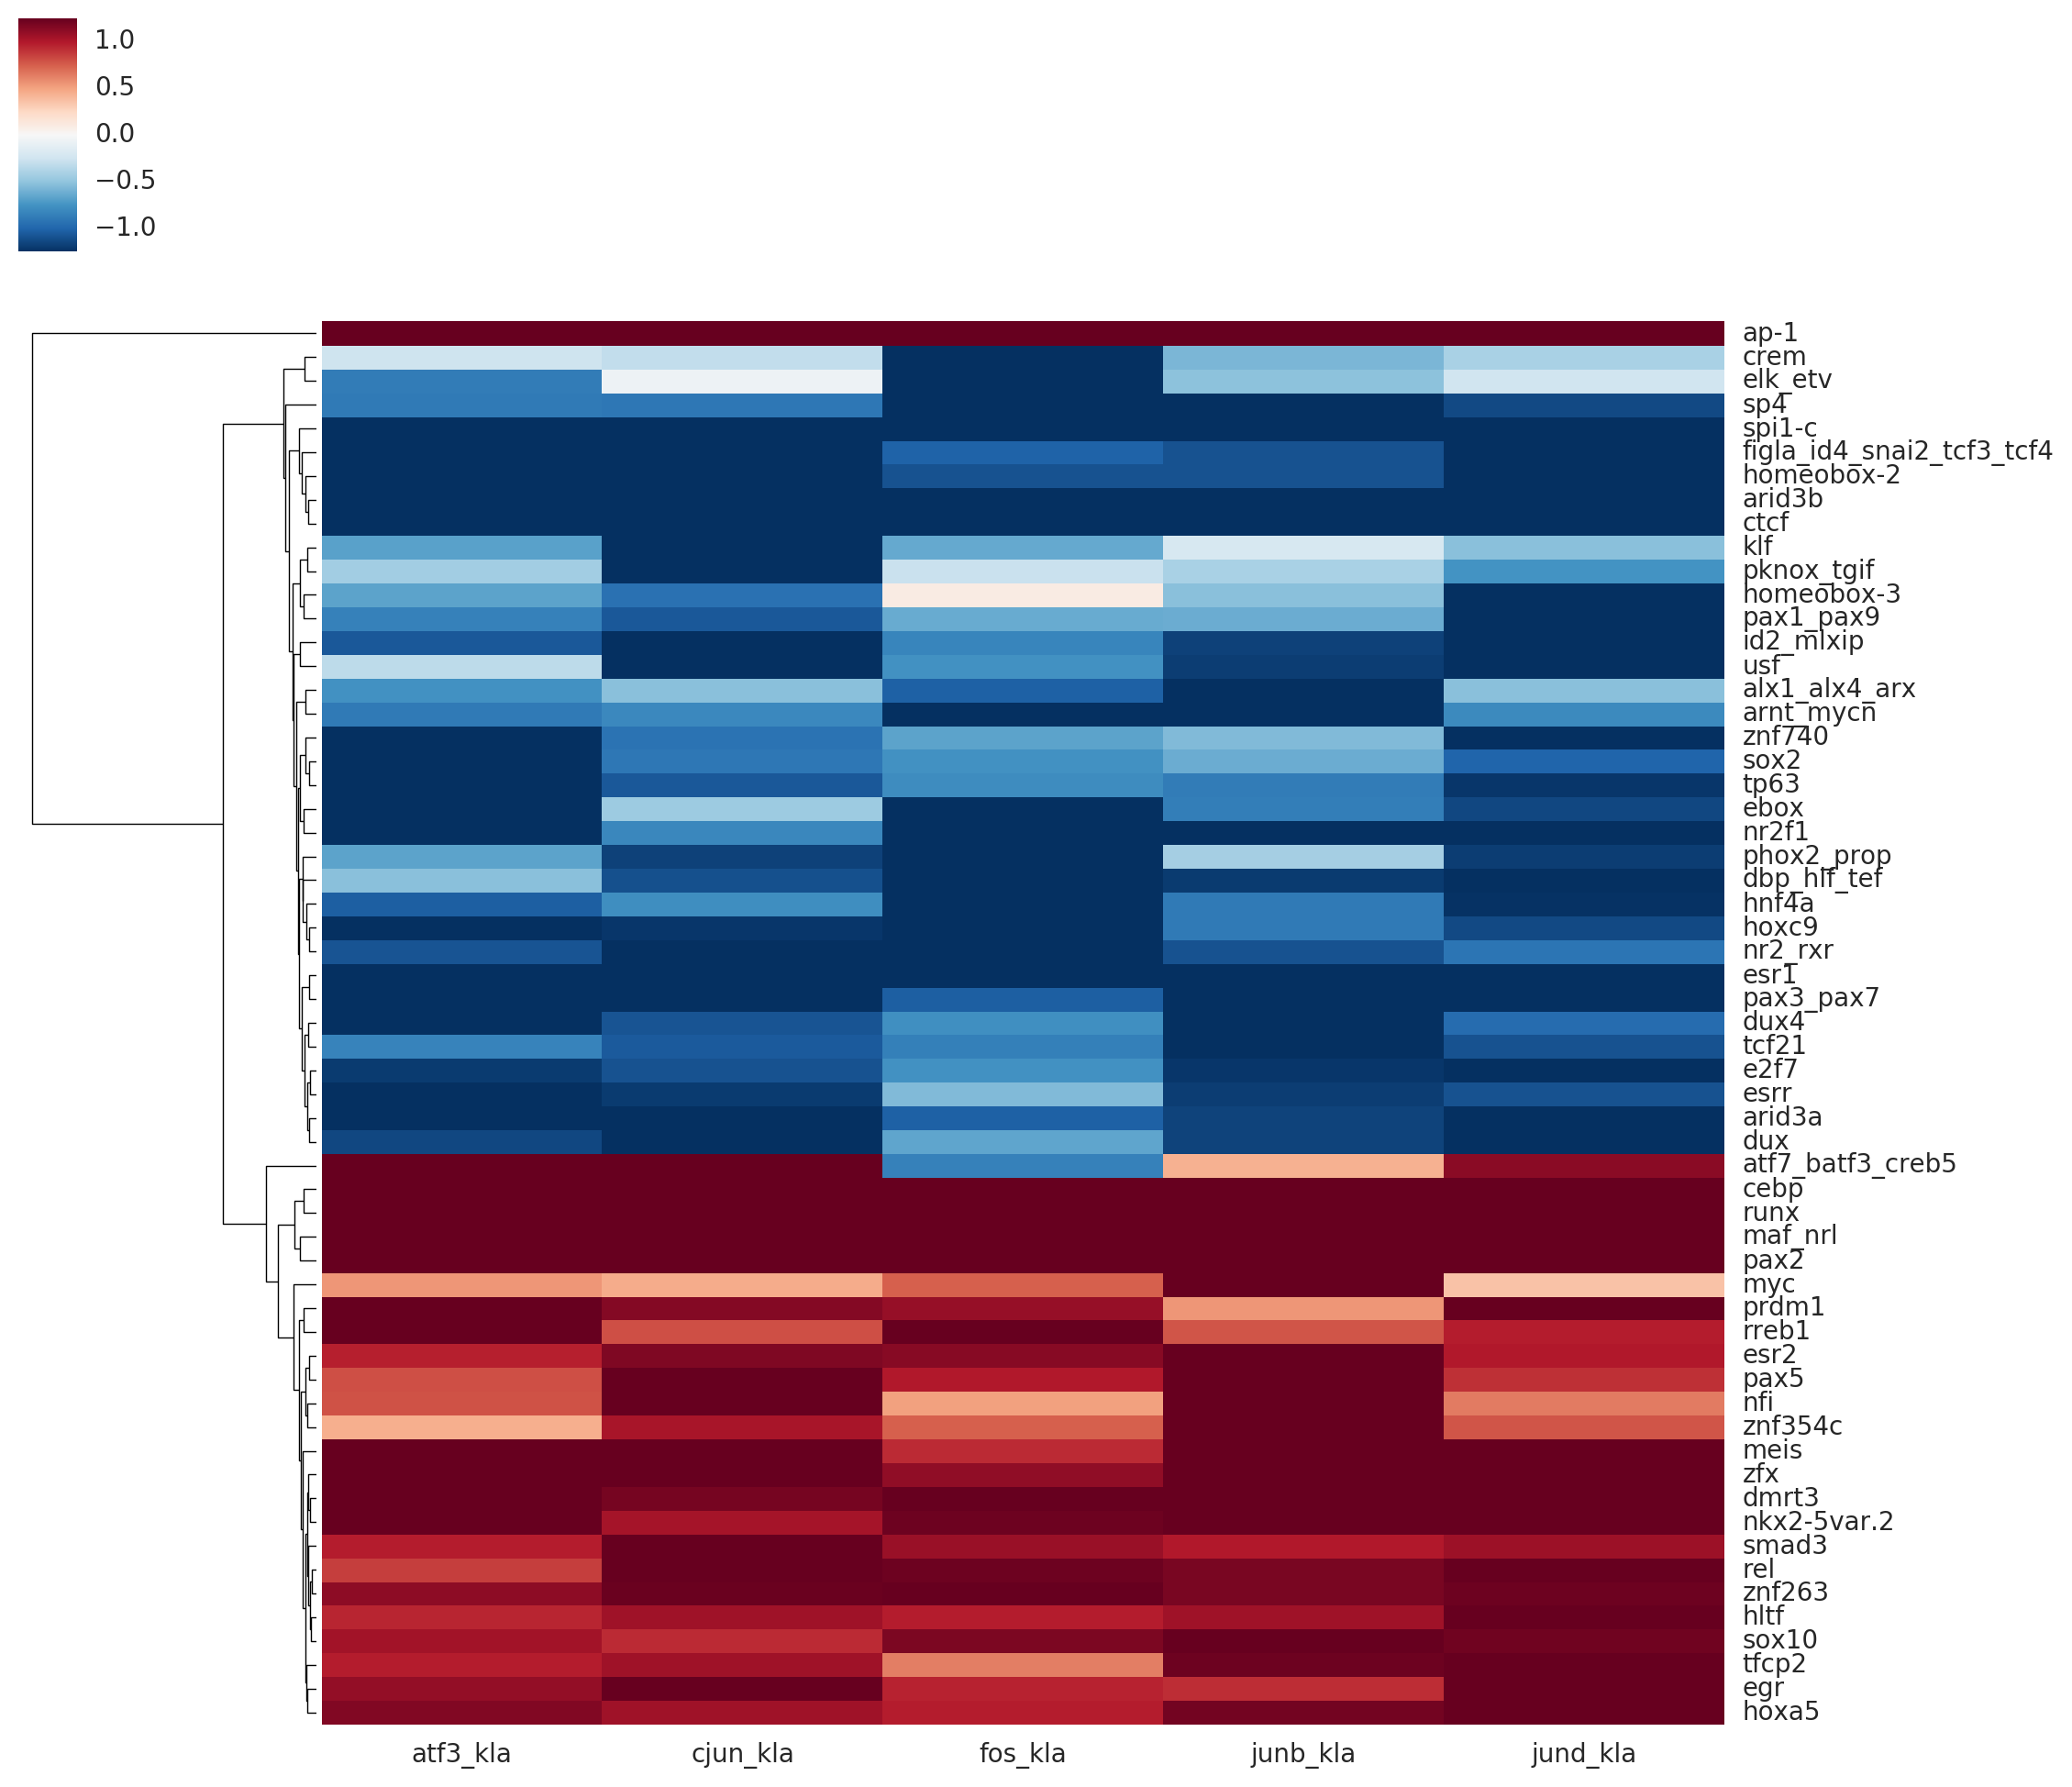

In [140]:
### plot coefficents for kla
weight_threshold = 1.25

cg = sns.clustermap(coefficients_zscore_frame_kla[(coefficients_zscore_frame_kla.max(axis=1) >= weight_threshold) |
                                       (coefficients_zscore_frame_kla.min(axis=1) < -1 * weight_threshold)
                                      ],
                   vmax= -1 * weight_threshold,
                   vmin= 1 * weight_threshold,
                    col_cluster=False,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_zscore_frame_kla.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
plt.savefig('./figures/figure_05_c.svg', bbox_inches='tight')

### Barplots showing inducible RNA-seq expression for significant motifs that are different between vehicle and KLA for cjun-jund, cjun-fos, atf3-cjun, atf3-jund, (all pairs with more than 5k peaks before and after treatment

In [27]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

In [145]:
difference_threshold = 2.0
motifs = coefficients_zscore_frame_veh.index.values
for fp in coefficients_zscore_frame_veh.columns.values:
    differences = coefficients_zscore_frame_kla[fp.replace('veh','kla')] - coefficients_zscore_frame_veh[fp]
    signs = coefficients_zscore_frame_kla[fp.replace('veh','kla')] * coefficients_zscore_frame_veh[fp]
    print('***', fp.replace('c57bl6_',''))
    for i in range(len(differences)):
        if abs(differences[i]) > difference_threshold:
            print('   ',motifs[i], differences[i])


*** atf3_veh
    ap-1 2.41598950458
    rel 3.06929768305
*** cjun_veh
    rel 2.81074069227
*** fos_veh
    ap-1 4.54206548622
    arid3b -2.30697426879
    ebox -2.01476654631
    nfyb -4.43855803992
    rel 2.08267242953
    rreb1 2.09398612466
    znf410 -9.15478072536
*** junb_veh
    ap-1 5.27668548395
    bhlhe23 -2.70643327536
    ctcf -2.18189029767
    dmbx1 -2.35171780768
    dux4 -3.23978738562
    maf_nrl 2.00036498346
    mecom -3.248636578
    meis 2.38887349555
    myog_tcf12 -2.08624145077
    mzf1 3.00148116421
    nfi 3.58359026
    pax2 2.38214208822
    pparg 2.10463164968
    runx 3.07980687555
    sp4 -2.98693703737
    srf -2.17601695831
    tfap1 2.38703717704
    tp63 -2.18195585599
    tp73 -2.12425310129
*** jund_veh
    rel 3.16196585233


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

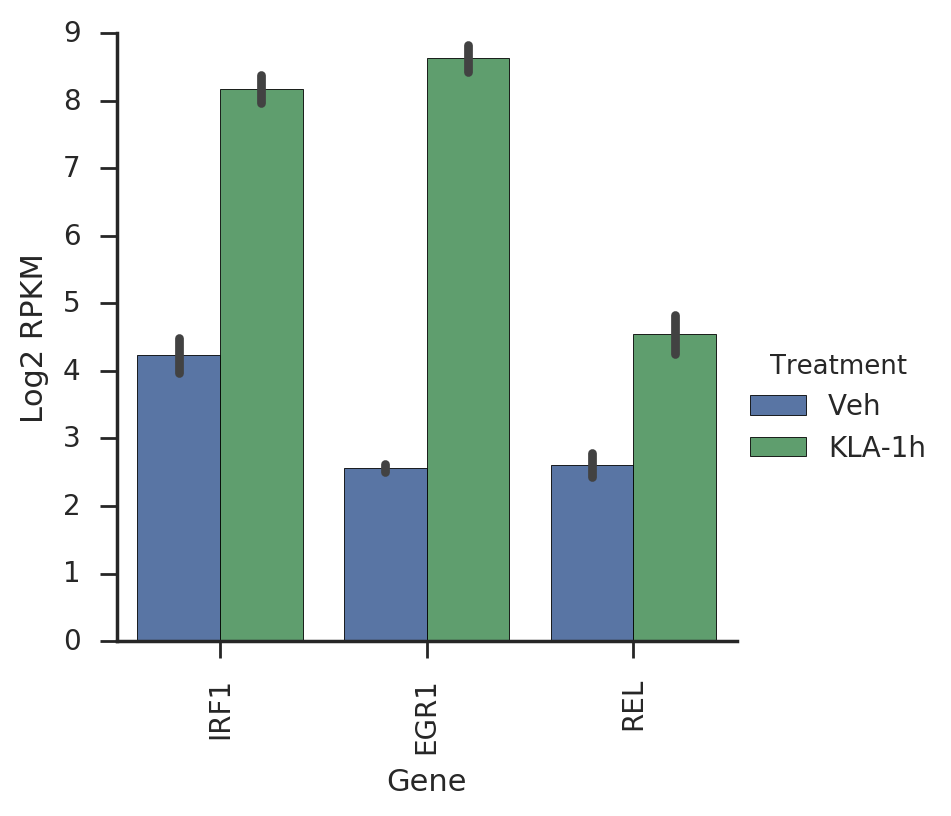

In [189]:
gene_list = ['REL', 'EGR1', 'ESR1', 'ESR2', 'RXRA', 'RXRB', 'IRF1', 'IRF7', 'IRF8', 'IRF9']
gene_list = ['IRF1', 'EGR1', 'REL']#, 'RXRA', 'RXRB','PPARG','NR1H2']


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Treatment', kind='bar', 
                   order = gene_list,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)

plt.xticks(rotation=90)


# Figure 6 - Strains Based Confirmation

### Run Verena's scripts

In [194]:
! if [ ! -d ./marge_files ]; then mkdir ./marge_files; fi
! if [ ! -d ./marge_output ]; then mkdir ./marge_output; fi

In [199]:
# read in best samples for use with annotation
# for c57bl6 samples
with open ('/home/jtao/analysis/ap1_analysis/best_samples.tsv') as f:
    data = f.readlines()
condition_samples_dict = {}
for line in data:
    tokens = line.strip().split('\t')
    condition = '_'.join(tokens[:3])
    samples = tokens[3:-1]
    condition_samples_dict[condition] = samples
    
# for nod and balbc
with open ('/home/jtao/analysis/ap1_analysis/best_samples_strains.tsv') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split('\t')
    condition = '_'.join(tokens[:3])
    samples = tokens[3:-1]
    condition_samples_dict[condition] = samples

In [200]:
strain_fullStrain_dict ={'balbc':'BALBCJ','c57bl6':'C57BL6J', 'nod':'NODSHILTJ'}

### Pairs of Factors

In [ ]:
c57bl6_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/'
strains_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/'
# create peak files for each dimer
### create peak files for denovo motif
peak_threshold = 50 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos','junb', 'jund']
strains = ['balbc','c57bl6']
for strain in strains:
    for treatment in ['veh', 'kla']:
        for i in range(len(factors) - 1):
            factor1 = strain + '_'+factors[i] + '_' + treatment
            for j in range(i + 1, len(factors)):
                factor2 = strain + '_'+ factors[j] + '_' + treatment
                if factor1 in summary_frame.columns and factor2 in summary_frame.columns:
                    outputPath = './marge_files/' + strain + '_' + factors[i] + '_' + factors[j] +'_' +treatment+ '_peaks.tsv'

                    current_frame = summary_frame[(summary_frame[factor1]> 0) &
                                                     (summary_frame[factor2] > 0)]

                    current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
                    current_peak_frame['strand'] = '+'
                    columns = current_peak_frame.columns.values
                    columns[0]='#PeakID'
                    current_peak_frame.columns = columns
                    if not os.path.isfile(outputPath):
                        if current_peak_frame.shape[0]  > peak_threshold:
                            current_peak_frame.to_csv(outputPath,
                                                     index=False,
                                                     sep='\t')
# create merged peak files for each pair of strains
for treatment in ['veh', 'kla']:
    for i in range(len(factors) - 1):
        factor1 = factors[i]
        for j in range(i + 1, len(factors)):
            factor2 = factors[j]
            for k in range(len(strains)-1):
                strain1 = strains[k]
                for l in range(k+1, len(strains)):
                    strain2 = strains[l]
                    strain1_path = './marge_files/' + '_'.join([strain1, factor1, factor2, treatment, 'peaks.tsv'])
                    strain2_path = './marge_files/' + '_'.join([strain2, factor1, factor2, treatment, 'peaks.tsv'])

                    if os.path.isfile(strain1_path) and os.path.isfile(strain2_path):
                        merged_file_path = './marge_files/' + '_'.join([strain1, strain2, factor1, factor2, treatment, 'mergedPeaks.tsv'])
                        if not os.path.isfile(merged_file_path):
                            print('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)
                            os.system('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)

                        # annotate merged peak files with best tag directories
                        strain1_samples = condition_samples_dict[strain1 + '_' + factor1 + '_'+treatment] + \
                                          condition_samples_dict[strain1 + '_' + factor2 + '_'+treatment]
                        strain2_samples = condition_samples_dict[strain2 + '_' + factor1 + '_'+treatment] + \
                                          condition_samples_dict[strain2 + '_' + factor2 + '_'+treatment]

                        strain1_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain1_samples]
                        strain2_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain2_samples]
                        annotated_file_path = merged_file_path.replace('merged','annotated')
                        if not os.path.isfile(annotated_file_path):
                            print('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                                  ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                            os.system('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                                  ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                        strain1_conditions = [strain1 + '_' + x.split('/')[-1].split('_')[3] for x in strain1_samples]
                        strain2_conditions = [strain2 + '_' + x.split('/')[-1].split('_')[3] for x in strain2_samples]

                        
                        # average tag counts from tag directories
                        averaged_file_path = annotated_file_path.replace(strain1, 'avg_'+strain1)
                        if not os.path.isfile(averaged_file_path):
                            print('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                     annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))
                            os.system('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                     annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))
                            
                        # sum up tag counts from both monomers
                        summed_file_path = annotated_file_path.replace('annotated','summed')
                        if not os.path.isfile(summed_file_path):
                            averaged_frame = pd.read_csv(averaged_file_path,sep='\t')
                            summed_frame = averaged_frame.ix[:,:7]
                            summed_frame[strain1] = np.sum(averaged_frame[[x for x in averaged_frame.columns if strain1 in x and 'avg'in x]], axis=1)
                            summed_frame[strain2] = np.sum(averaged_frame[[x for x in averaged_frame.columns if strain2 in x and 'avg'in x]], axis=1)
                            summed_frame.to_csv(summed_file_path, sep='\t', index=False)
#                         # call mutation analysis script
                        print('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
                              '-genome mm10 -strains ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
                              ' -file ' + summed_file_path + ' -AB ap-1 -output ' + '_'.join([strain1, strain2, factor1, factor2, treatment]) +
                              ' -plots plot_' + '_'.join([strain1, strain2, factor1, factor2, treatment]))
                              
                        os.system('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
                              '-genome mm10 -strains ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
                              ' -file ' + summed_file_path + ' -AB ap-1 -output ./marge_output/' + '_'.join([strain1, strain2, factor1, factor2, treatment]) +
                              ' -plots ./marge_output/plot_' + '_'.join([strain1, strain2, factor1, factor2, treatment]))

      


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl -genome mm10 -strains BALBCJ, C57BL6J -file ./marge_files/balbc_c57bl6_cjun_fos_veh_summedPeaks.tsv -AB ap-1 -output balbc_c57bl6_cjun_fos_veh -plots plot_balbc_c57bl6_cjun_fos_veh


### individual factors

In [ ]:
c57bl6_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/'
strains_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/'
# create peak files for each dimer
### create peak files for denovo motif
peak_threshold = 50 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos','junb', 'jund']
strains = ['balbc','c57bl6']
for strain in strains:
    for treatment in ['veh', 'kla']:
        for i in range(len(factors) - 1):
            factor1 = strain + '_'+factors[i] + '_' + treatment

            if factor1 in summary_frame.columns:
                outputPath = './marge_files/' + strain + '_' + factors[i] +'_' +treatment+ '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1]> 0)]

                current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
                current_peak_frame['strand'] = '+'
                columns = current_peak_frame.columns.values
                columns[0]='#PeakID'
                current_peak_frame.columns = columns
                if not os.path.isfile(outputPath):
                    if current_peak_frame.shape[0]  > peak_threshold:
                        current_peak_frame.to_csv(outputPath,
                                                 index=False,
                                                 sep='\t')
# create merged peak files for each pair of strains
for treatment in ['veh', 'kla']:
    for i in range(len(factors) - 1):
        factor1 = factors[i]

        for k in range(len(strains)-1):
            strain1 = strains[k]
            for l in range(k+1, len(strains)):
                strain2 = strains[l]
                strain1_path = './marge_files/' + '_'.join([strain1, factor1, treatment, 'peaks.tsv'])
                strain2_path = './marge_files/' + '_'.join([strain2, factor1, treatment, 'peaks.tsv'])

                if os.path.isfile(strain1_path) and os.path.isfile(strain2_path):
                    merged_file_path = './marge_files/' + '_'.join([strain1, strain2, factor1, treatment, 'mergedPeaks.tsv'])
                    if not os.path.isfile(merged_file_path):
                        print('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)
                        os.system('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)

                    # annotate merged peak files with best tag directories
                    strain1_samples = condition_samples_dict[strain1 + '_' + factor1 + '_'+treatment]
                    strain2_samples = condition_samples_dict[strain2 + '_' + factor1 + '_'+treatment]

                    strain1_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain1_samples]
                    strain2_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain2_samples]
                    annotated_file_path = merged_file_path.replace('merged','annotated')
                    if not os.path.isfile(annotated_file_path):
                        print('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                              ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                        os.system('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                              ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                    strain1_conditions = [strain1 + '_' + x.split('/')[-1].split('_')[3] for x in strain1_samples]
                    strain2_conditions = [strain2 + '_' + x.split('/')[-1].split('_')[3] for x in strain2_samples]


                    # average tag counts from tag directories
                    averaged_file_path = annotated_file_path.replace(strain1, 'avg_'+strain1)
                    if not os.path.isfile(averaged_file_path):
                        print('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                 annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))
                        os.system('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                 annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))

                    # sum up tag counts from both monomers
                    summed_file_path = annotated_file_path.replace('annotated','summed')
                    if not os.path.isfile(summed_file_path):
                        averaged_frame = pd.read_csv(averaged_file_path,sep='\t')
                        summed_frame = averaged_frame.ix[:,:7]
                        summed_frame[strain1] = np.sum(averaged_frame[[x for x in averaged_frame.columns if strain1 in x and 'avg'in x]], axis=1)
                        summed_frame[strain2] = np.sum(averaged_frame[[x for x in averaged_frame.columns if strain2 in x and 'avg'in x]], axis=1)
                        summed_frame.to_csv(summed_file_path, sep='\t', index=False)
#                         # call mutation analysis script
                    print('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
                          '-genome mm10 -strains ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
                          ' -file ' + summed_file_path + ' -AB ap-1 -output ' + '_'.join([strain1, strain2, factor1, treatment]) +
                          ' -plots plot_' + '_'.join([strain1, strain2, factor1,  treatment]))

                    os.system('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
                          '-genome mm10 -strains ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
                          ' -file ' + summed_file_path + ' -AB ap-1 -output ./marge_output/' + '_'.join([strain1, strain2, factor1, treatment]) +
                          ' -plots ./marge_output/plot_' + '_'.join([strain1, strain2, factor1,  treatment]))

      



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


annotatePeaks.pl ./marge_files/balbc_c57bl6_atf3_veh_mergedPeaks.tsv mm10 -noann -nogene -d /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16-rep1 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23>./marge_files/balbc_c57bl6_atf3_veh_annotatedPeaks.tsv
/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ./marge_files/balbc_c57bl6_atf3_veh_annotatedPeaks.tsv balbc_ATF3 balbc_ATF3 c57bl6_ATF3 c57bl6_ATF3
/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl -genome mm10 -strains BALBCJ, C57BL6J -file ./marge_files/balbc_c57bl6_atf3_veh_summedPeaks.tsv -AB ap-1 -output balbc_c57bl6_atf3_veh -plots plot_balbc_

# Figure 7 - Validation Experiment

# Figure 8 - RNA-seq and GRO-seq

### Scatter plot for jun knockdown (wt-veh vs siJun-veh)

### Scatter plot for jun knockdown (wt-KLA vs siJun-KLA)

### Scatter plot comparing two knockdowns (siATF3 vs siJun veh)

### GO analysis for knockdowns as a heatmap

### GRO-seq fold change plot for AP-1 dimers

In [189]:
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    


for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [190]:
# get peak IDS for peaks

reads = []
factors = []
treatments = []
fold_changes = []
for treatment in ['Veh','KLA', 'Both']:
    for fp in factorPairs:
        factor_auc_dict = {}
        factor1 = fp[0] + '_' + treatment.lower()
        factor2 = fp[1] + '_' + treatment.lower()
        
        if treatment == 'Veh':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('veh','kla')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('veh','kla')] == 0)].index.values)
        elif treatment == 'KLA':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('kla','veh')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('kla','veh')] == 0)].index.values)


        else:
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('both','kla')] > 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('both','kla')] > 0)].index.values)

            
        indices = indices1.intersection(indices2)
        if not treatment == 'Both':
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_'+ treatment +' +', 'Gro_'+treatment+ ' -']].sum(axis=1)
        else:
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_Veh +', 'Gro_Veh -', 'Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        veh_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_Veh +', 'Gro_Veh -']].sum(axis=1)
        kla_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        
        factors = factors + [' '.join(fp).replace('c57bl6_','')] * len(gro_reads)
        treatments = treatments + [treatment] * len(gro_reads)
        reads = reads + list(gro_reads)
        fold_changes = fold_changes + list((kla_reads + 0.1)/(veh_reads + 0.1))




In [191]:
# # get peak IDS for peaks

# reads = []
# factors = []
# treatments = []
# fold_changes = []
# for treatment in ['Veh','KLA', 'Both']:
#     for monomer in ap1_members:       
#         if treatment == 'Veh':
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_veh'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_kla'] == 0)].index.values)
#         elif treatment == 'KLA':
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_kla'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_veh'] == 0)].index.values)

#         else:
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_veh'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_kla'] > 0)].index.values)
#         if not treatment == 'Both':
#             gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#                 [['Gro_'+ treatment +' +', 'Gro_'+treatment+ ' -']].sum(axis=1)
#         else:
#             gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#                 [['Gro_Veh +', 'Gro_Veh -', 'Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
#         veh_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#             [['Gro_Veh +', 'Gro_Veh -']].sum(axis=1)
#         kla_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#             [['Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        
#         factors = factors + [monomer] * len(gro_reads)
#         treatments = treatments + [treatment] * len(gro_reads)
#         reads = reads + list(gro_reads)
#         fold_changes = fold_changes + list((kla_reads + 0.01)/(veh_reads + 0.01))





In [192]:
gro_frame = pd.DataFrame({'Dimer':factors,
                          'Treatment':treatments,
                          'GRO-seq Tags':reads,
                          'Log2 GRO-seq Tags': np.log2(np.array(reads)+1),
                          'Fold Change':fold_changes,
                          'Log2 Fold Change': np.log2(np.array(fold_changes))
                          })

gro_frame['Treatment'] = ['Lost After Treatment' if x == 'Veh' else 'Unchanged' if x=='Both' else 'Gained After Treatment' for x in gro_frame['Treatment'].values]

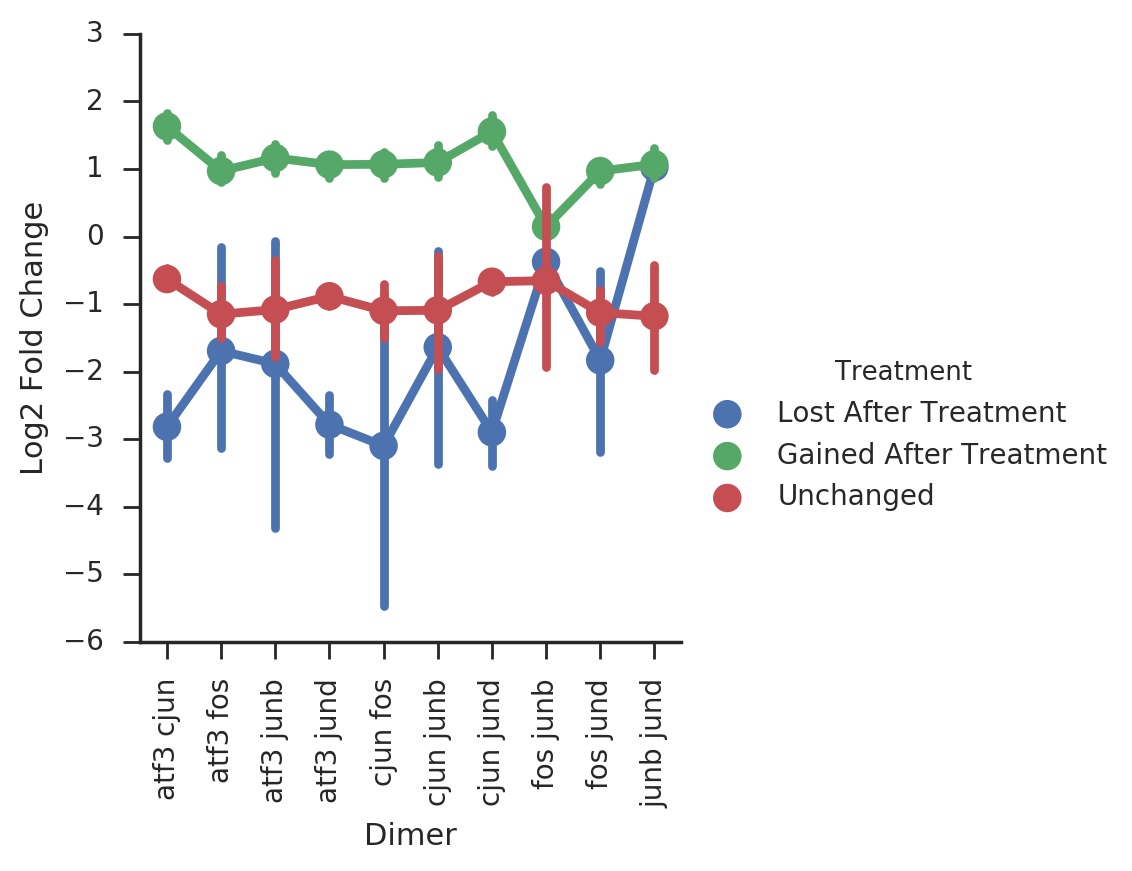

In [193]:
with sns.axes_style('ticks'):
    sns.factorplot( data = gro_frame,
                x='Dimer',
                y= 'Log2 Fold Change',
                hue='Treatment',
                size=4,
                ci=100)
    plt.xticks(rotation=90)
    plt.savefig('./figures/figure_08_e.pdf',bbox_inches='tight')

### GO analysis for nearest gene

# Figure 9 - Graphical abstract

# Supplemental Materials

### Classifier performance on different test fractions

### De novo motifs for all dimers

### Motif compression stuff